<a href="https://colab.research.google.com/github/hhboorstein/ds_portfolio/blob/main/DSBA_Unsupervised_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning: StockCenter


Use K-means and Hierarchical clustering techniques to group stocks. StockCenter can use this information to compile a portfolio containing similar performing securities across various sectors.

Attributes:

* `Ticker Symbol`: Stock abbreviation
* `Security`: Company Name
* `GICS Sector`: Global Industry Classification Standard economic sector designation
* `GICS Sub Industry`: GICS-designated economic sub-industry
* `Current Price`: Stock price in USD
* `Price Change`: Percent change in price (last 13 weeks)
* `Volatility`: Standard deviation in price (last 13 weeks)
* `ROE`: Net income divided by shareholder equity, where shareholder equity is a company's assets less debts
* `Cash Ratio`: Cash and cash equivalents divided by total liabilities
* `Net Cash Flow`:  Difference between cash inflow and outflow in USD
* `Net Income`: Company revenue minus expenses, interest, and taxes (USD)
* `Earnings Per Share`: Net profit over outstanding common shares (USD/share)
* `Estimated Shares Outstanding`: Shareholder-held stock
* `P/E Ratio`: Stock price divided by earnings per share
* `P/B Ratio`: Stock price divided by company book value per share, where book value is total assets less total liabilities

## Importing necessary libraries and data

In [ ]:
! pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 64.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [ ]:
import numpy as np
import pandas as pd

# visualization
from matplotlib import pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram

# normalization, distance, and correlation functions
from scipy.stats import zscore
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, cophenet
from sklearn.metrics import silhouette_score

# clustering
from sklearn.cluster import KMeans, AgglomerativeClustering

In [ ]:
df=pd.read_csv('stock_data.csv')
data=df.copy()

In [ ]:
sns.set_theme()

## Data Overview

In [ ]:
data.sample(10,random_state=1)

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
102,DVN,Devon Energy Corp.,Energy,Oil & Gas Exploration & Production,32.000000,-15.478079,2.923698,205,70,830000000,-14454000000,-35.55,4.065823e+08,93.089287,1.785616
125,FB,Facebook,Information Technology,Internet Software & Services,104.660004,16.224320,1.320606,8,958,592000000,3669000000,1.31,2.800763e+09,79.893133,5.884467
11,AIV,Apartment Investment & Mgmt,Real Estate,REITs,40.029999,7.578608,1.163334,15,47,21818000,248710000,1.52,1.636250e+08,26.335526,-1.269332
248,PG,Procter & Gamble,Consumer Staples,Personal Products,79.410004,10.660538,0.806056,17,129,160383000,636056000,3.28,4.913916e+08,24.070121,-2.256747
238,OXY,Occidental Petroleum,Energy,Oil & Gas Exploration & Production,67.610001,0.865287,1.589520,32,64,-588000000,-7829000000,-10.23,7.652981e+08,93.089287,3.345102
336,YUM,Yum! Brands Inc,Consumer Discretionary,Restaurants,52.516175,-8.698917,1.478877,142,27,159000000,1293000000,2.97,4.353535e+08,17.682214,-3.838260
112,EQT,EQT Corporation,Energy,Oil & Gas Exploration & Production,52.130001,-21.253771,2.364883,2,201,523803000,85171000,0.56,1.520911e+08,93.089287,9.567952
147,HAL,Halliburton Co.,Energy,Oil & Gas Equipment & Services,34.040001,-5.101751,1.966062,4,189,7786000000,-671000000,-0.79,8.493671e+08,93.089287,17.345857
89,DFS,Discover Financial Services,Financials,Consumer Finance,53.619999,3.653584,1.159897,20,99,2288000000,2297000000,5.14,4.468872e+08,10.431906,-0.375934
173,IVZ,Invesco Ltd.,Financials,Asset Management & Custody Banks,33.480000,7.067477,1.580839,12,67,412000000,968100000,2.26,4.283628e+08,14.814159,4.218620


There are two unique identifiers for each record: ticker symbol and security. Both a general sector and a sub-industry are described as well.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

Most of our attributes are numerical, with about twice as many floats to ints. There are no null entries.

## Exploratory Data Analysis (EDA)

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Current Price,340.0,8.086234e+01,9.805509e+01,4.500000e+00,3.855500e+01,5.970500e+01,9.288000e+01,1.274950e+03
Price Change,340.0,4.078194e+00,1.200634e+01,-4.712969e+01,-9.394838e-01,4.819505e+00,1.069549e+01,5.505168e+01
Volatility,340.0,1.525976e+00,5.917984e-01,7.331632e-01,1.134878e+00,1.385593e+00,1.695549e+00,4.580042e+00
ROE,340.0,3.959706e+01,9.654754e+01,1.000000e+00,9.750000e+00,1.500000e+01,2.700000e+01,9.170000e+02
Cash Ratio,340.0,7.002353e+01,9.042133e+01,0.000000e+00,1.800000e+01,4.700000e+01,9.900000e+01,9.580000e+02
Net Cash Flow,340.0,5.553762e+07,1.946365e+09,-1.120800e+10,-1.939065e+08,2.098000e+06,1.698108e+08,2.076400e+10
Net Income,340.0,1.494385e+09,3.940150e+09,-2.352800e+10,3.523012e+08,7.073360e+08,1.899000e+09,2.444200e+10
Earnings Per Share,340.0,2.776662e+00,6.587779e+00,-6.120000e+01,1.557500e+00,2.895000e+00,4.620000e+00,5.009000e+01
Estimated Shares Outstanding,340.0,5.770283e+08,8.458496e+08,2.767216e+07,1.588482e+08,3.096751e+08,5.731175e+08,6.159292e+09
P/E Ratio,340.0,3.261256e+01,4.434873e+01,2.935451e+00,1.504465e+01,2.081988e+01,3.176476e+01,5.280391e+02


* Many values are in the millions or billions.
* Net cash flow and net income have some of the highest values, along with some of the lowest.
* The mean P/E ratio is positive, while the mean P/B ratio is negative.

In [ ]:
data.describe(include='object').T

,count,unique,top,freq
Ticker Symbol,340,340,AAL,1
Security,340,340,American Airlines Group,1
GICS Sector,340,11,Industrials,53
GICS Sub Industry,340,104,Oil & Gas Exploration & Production,16


The most common sector in our data is industrials, and the most common sub-industry is Oil & Gas Exploration & Production.

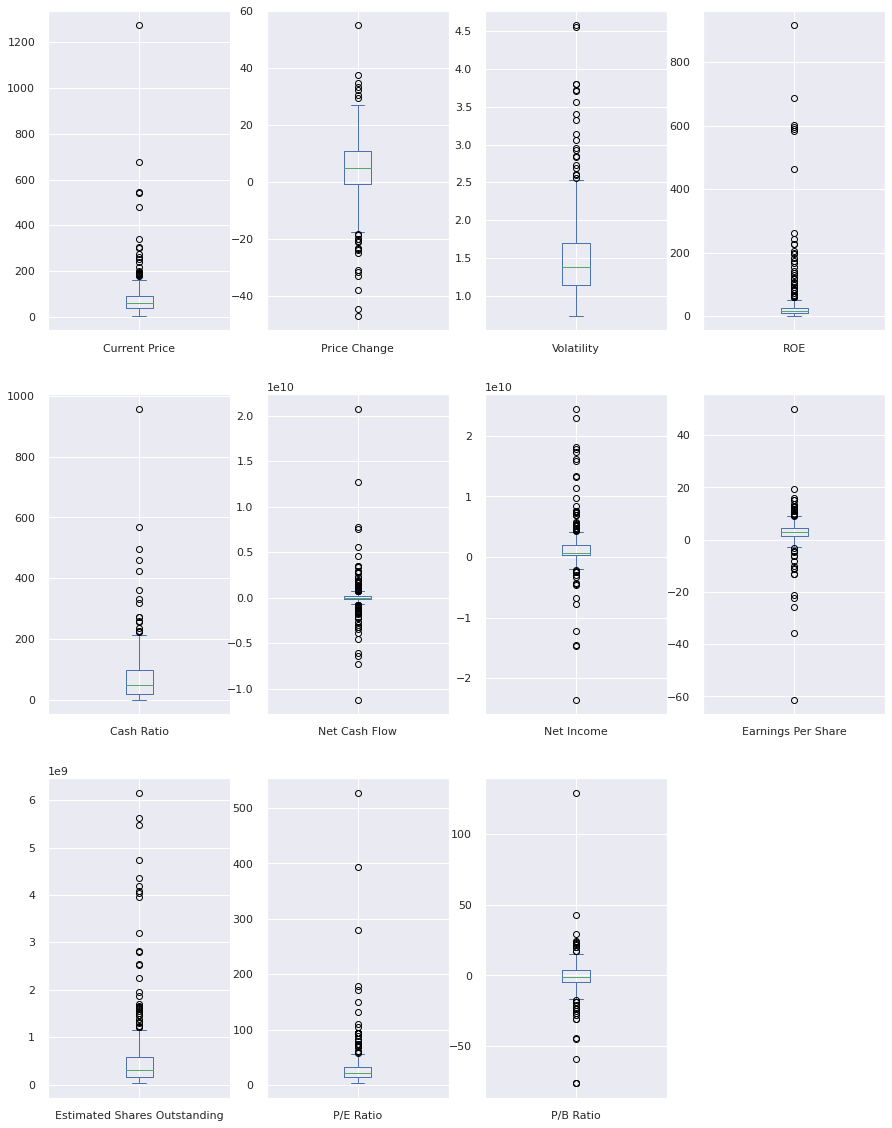

In [ ]:
# boxplots
data.plot(
    kind='box',
    subplots=True,
    sharey=False,
    layout=(3,4),
    figsize=(15,20));

* Every attribute shows evidence of many outliers, indicating the broad spread of the data.
* Net cash flow is fairly concentrated around 0, though the minimum and maximum are respectively massive.
* The distribution of price change appears fairly balanced.
* ROE is concentrated near 0, with roughly two pockets of data above.
* Cash ratio has a singe value far outside the rest of the data, as does P/B ratio.

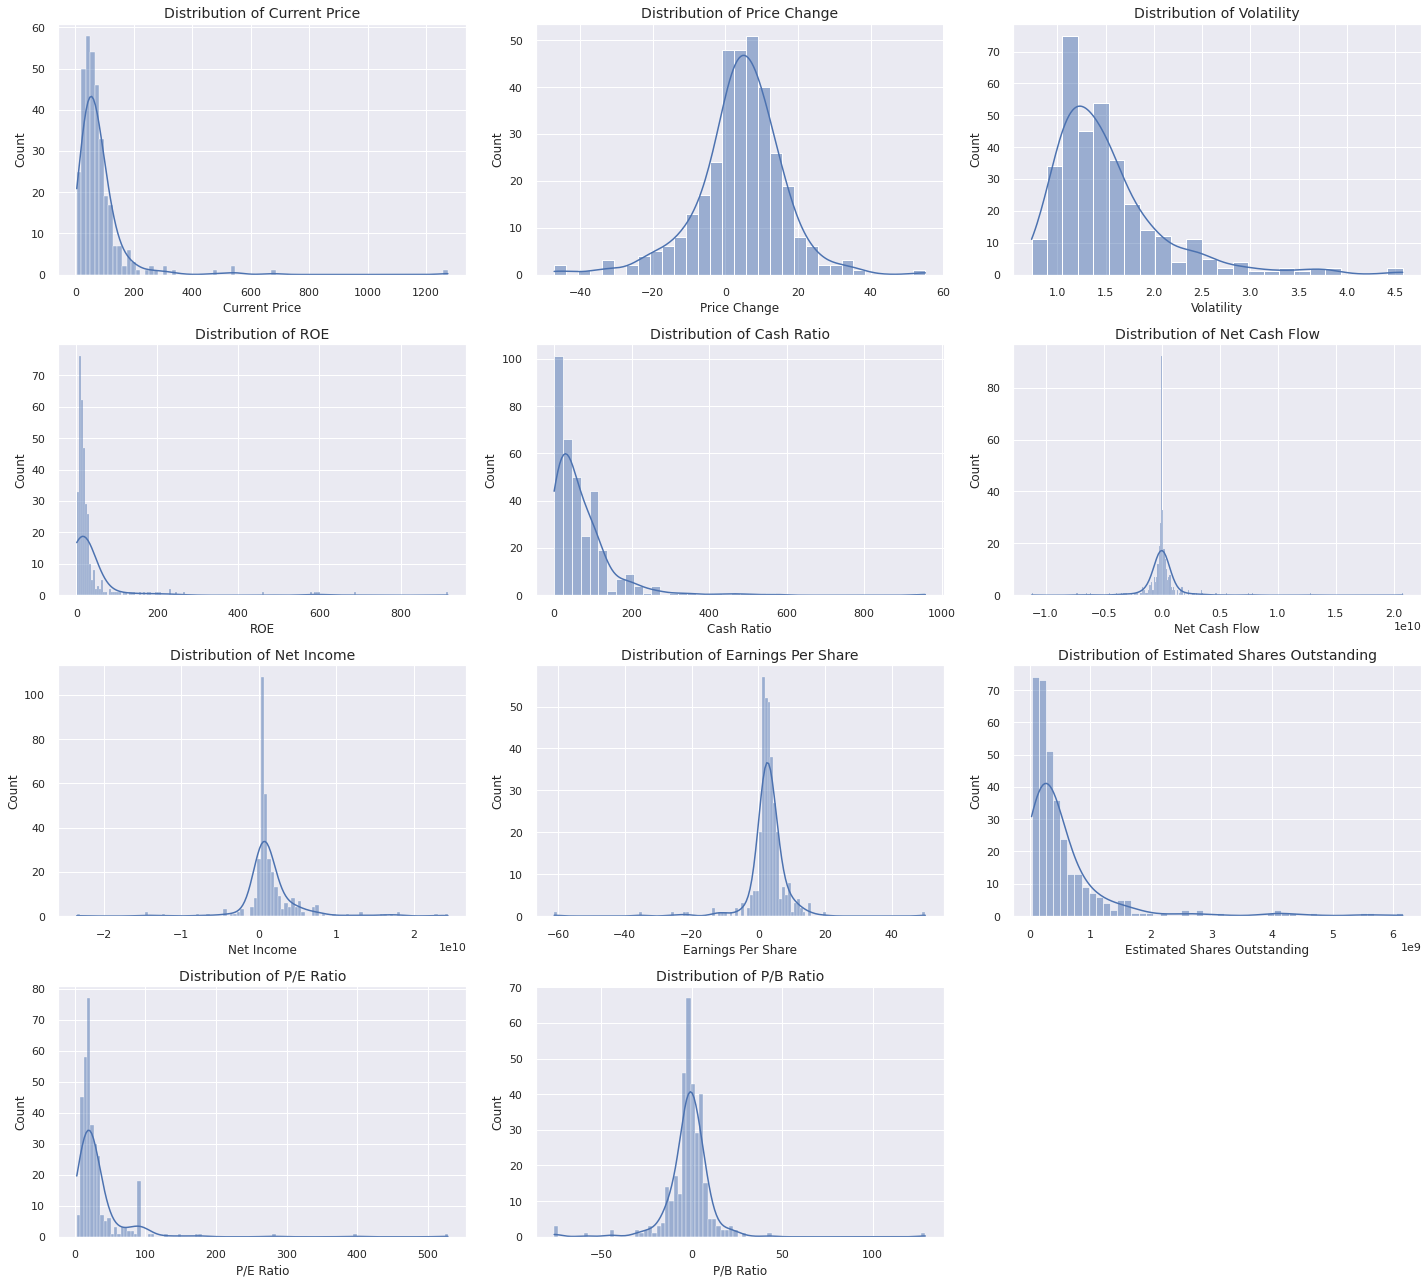

In [ ]:
# histograms
plt.figure(figsize=(20,18))
for idx,col in enumerate(data.select_dtypes(np.number).columns):
  plt.subplot(4,3,idx+1)
  plt.title('Distribution of '+str(col),fontsize=14)
  sns.histplot(data[col],kde=True)
plt.tight_layout()

* The distribution of stock prices is heavily right-skewed.
* Moreover, volatility, ROE, cash ratio, estimated shares outstanding, and P/E ratio are right-skewed.
* Net cash flow is very tightly concentrated about 0 with long tails. Net income is similar, although not as tightly concentrated.
* P/E has a second peak that appears out of nowhere to the right of the mean.

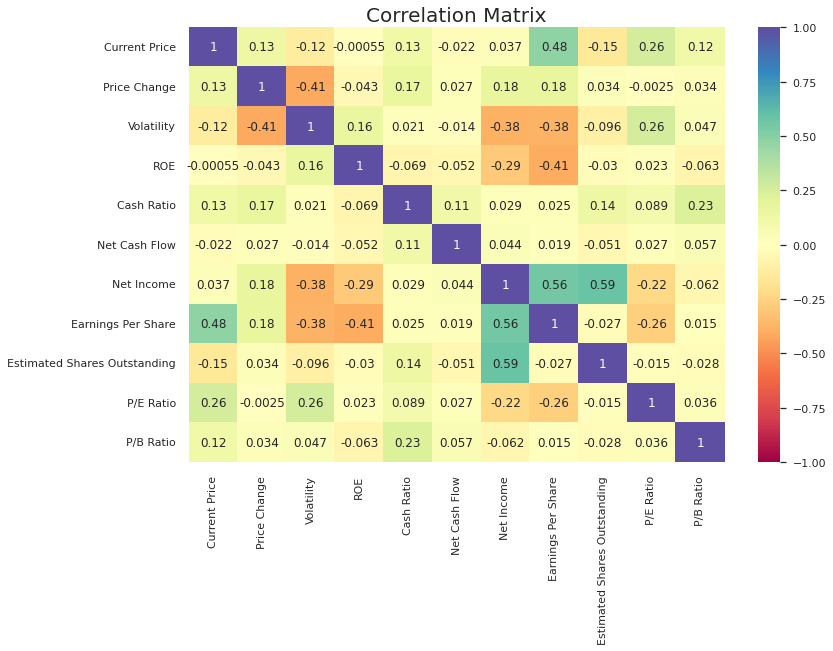

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Correlation Matrix',fontsize=20)
sns.heatmap(
    data=data.corr(),
    vmin=-1,
    cmap='Spectral',
    annot=True
);

The matrix above shows the correlation between the different variables.
* Net income is positively correlated with earnings per share and estimated shares outstanding.
* Volatility is negatively correlated with price change, net income, and earnings per share. Earnings per share is also negatively correlated with ROE.
* Earnings per share and current price are positively correlated.

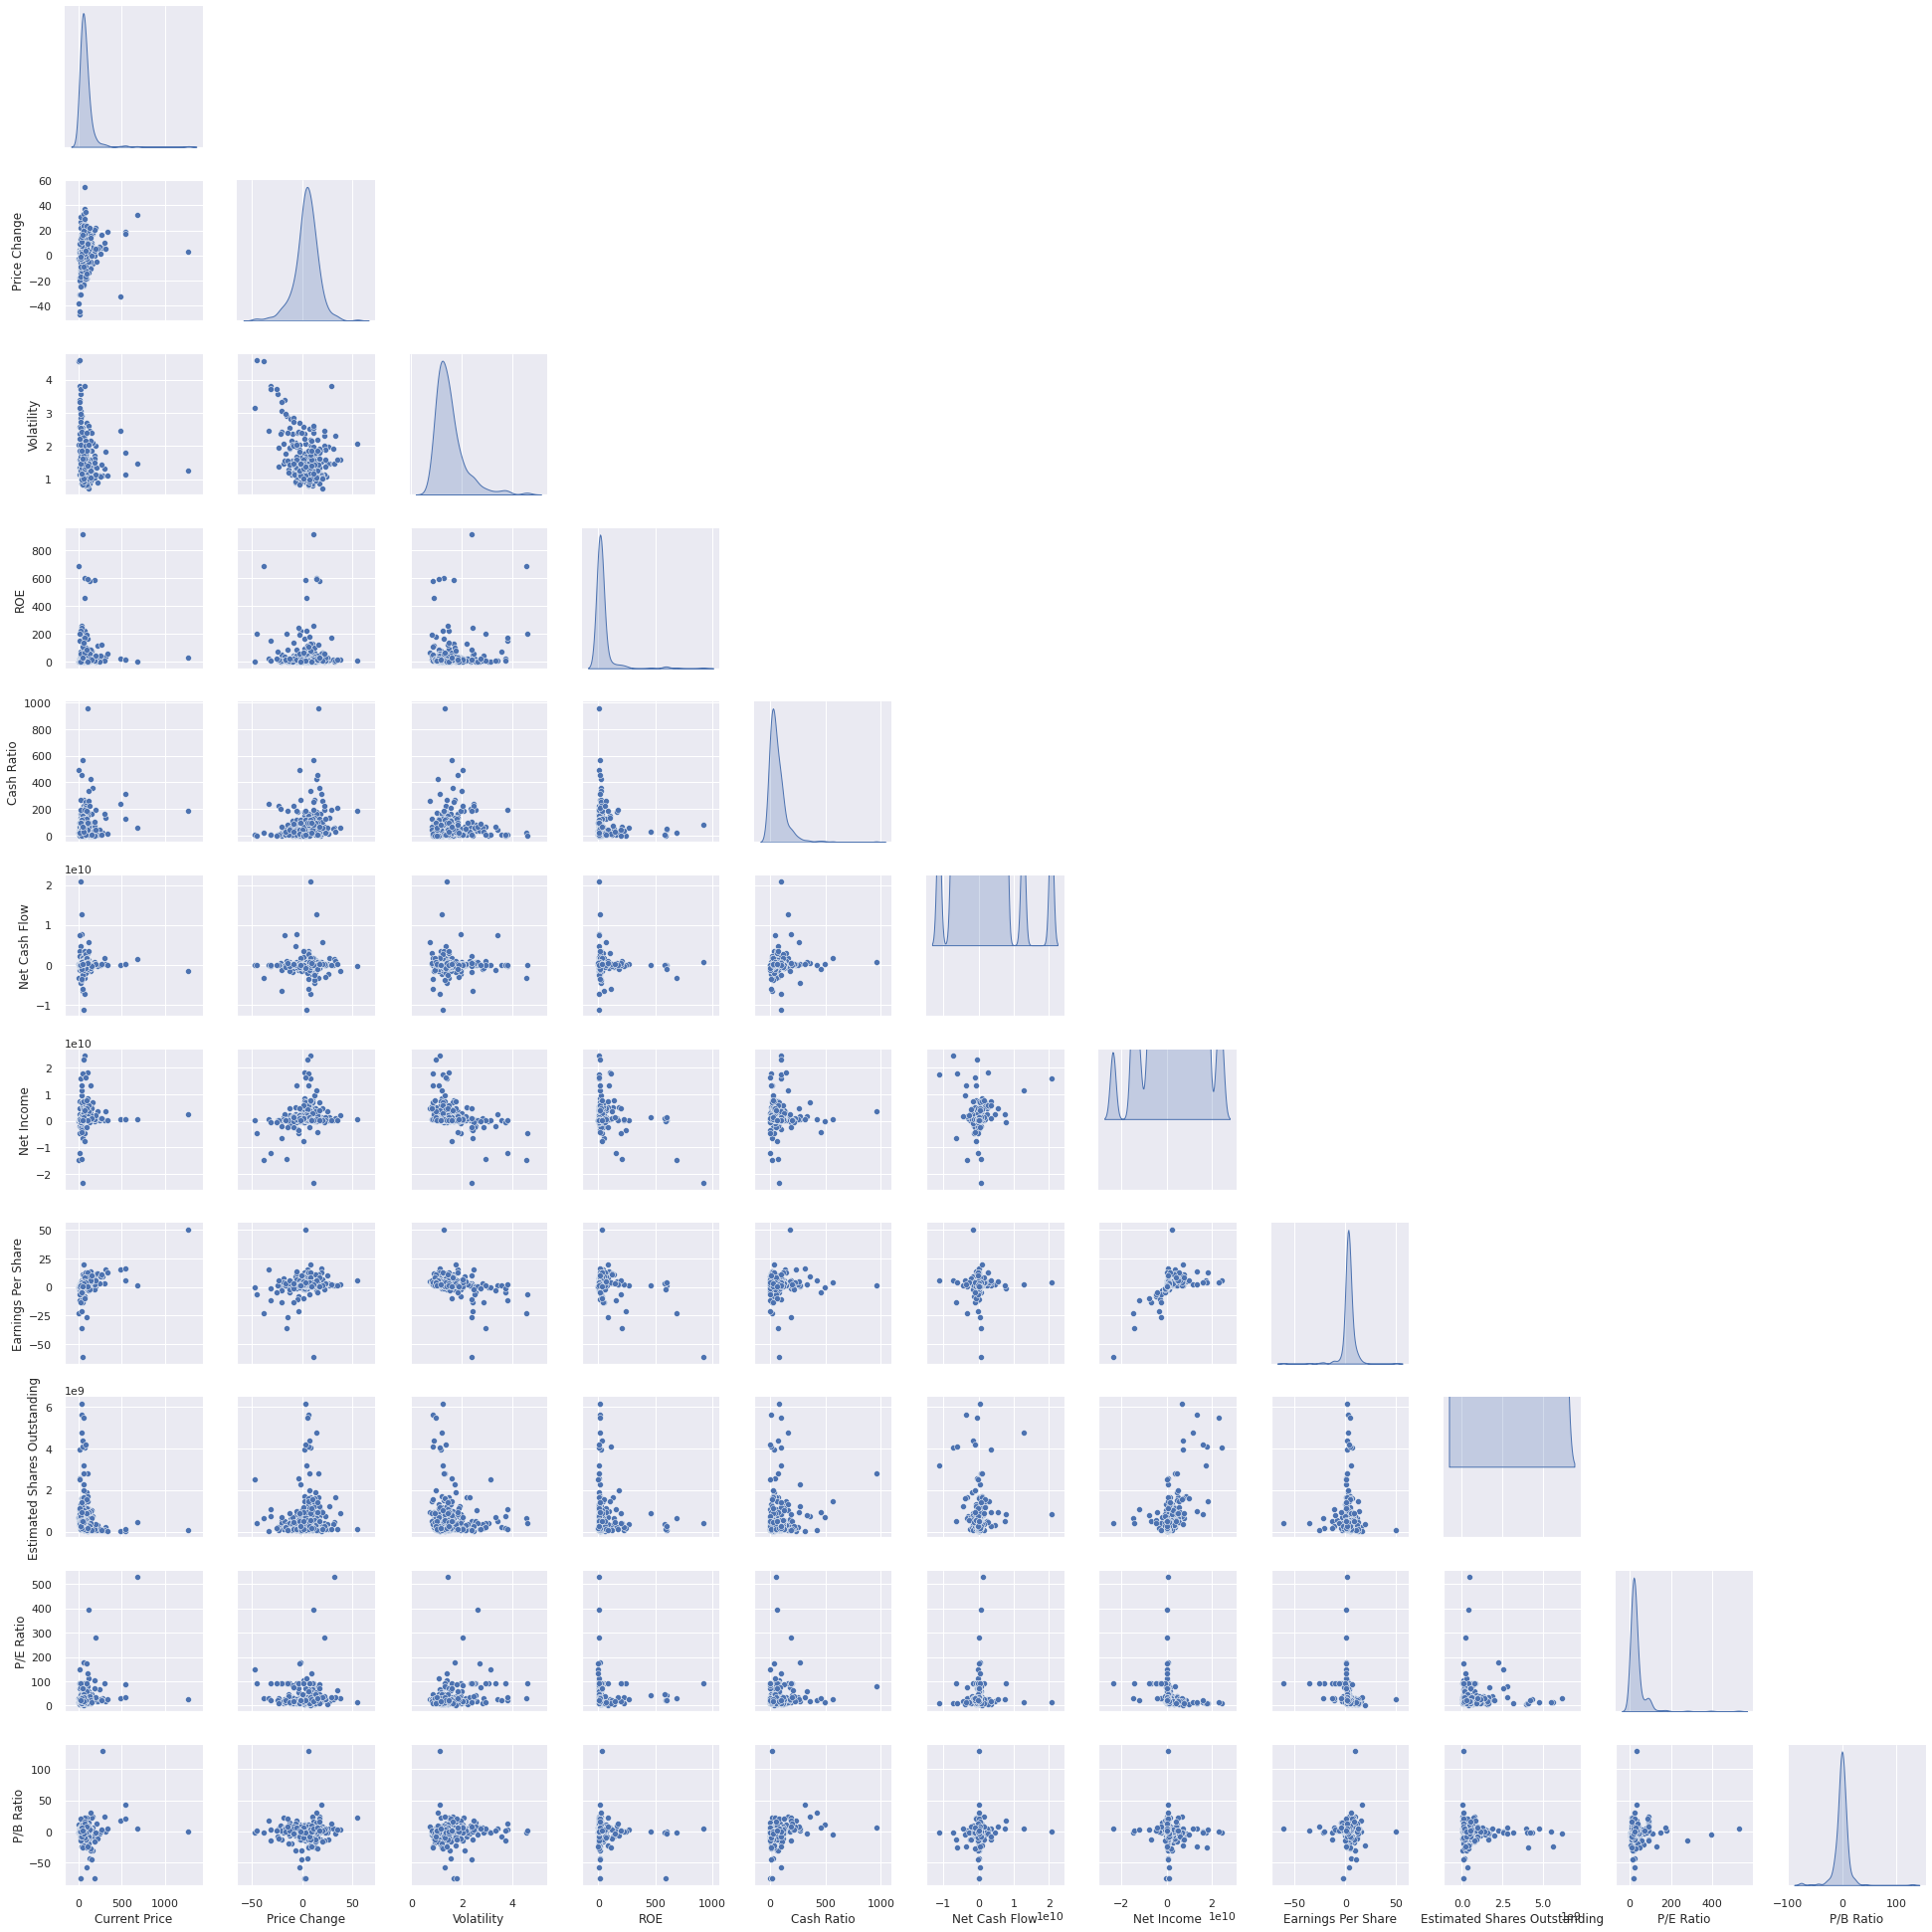

In [ ]:
sns.pairplot(data,diag_kind='kde',corner=True);

There are no immediately visible trends in the paired scatterplot.

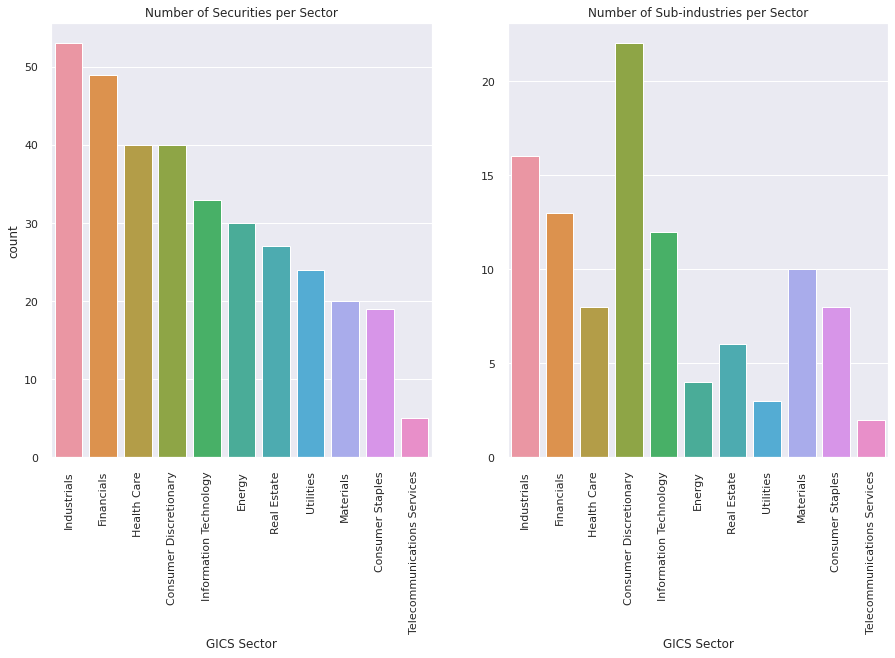

In [ ]:
subind=data.groupby('GICS Sector')['GICS Sub Industry'].nunique()

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title('Number of Securities per Sector')
sns.countplot(
    x=data['GICS Sector'],
    order=data['GICS Sector'].value_counts().index)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
plt.title('Number of Sub-industries per Sector')
sns.barplot(
    x=subind.index,
    y=subind.values,
    order=data['GICS Sector'].value_counts().index)
plt.xticks(rotation=90)

plt.show()

On the left, we see the number of records per sector. The plot on the right shows the number of sub-industries in each sector.
* Industrials has the most records in our data set, followed by financials, health care, and consumer discretionary.
* Consumer discretionary, however, boasts the most sub-industries.

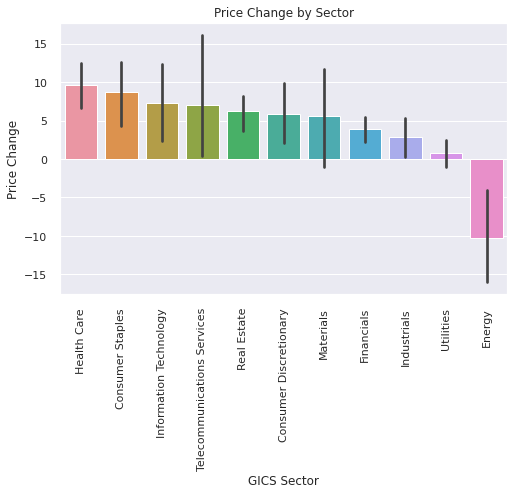

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Price Change by Sector')
sns.barplot(
    data=data,
    x='GICS Sector',
    y='Price Change',
    order=(data
           .groupby('GICS Sector')['Price Change']
           .mean()
           .sort_values(ascending=False)
           .index))
plt.xticks(rotation=90);

This plot shows price change by GICS sector, sorted by mean price increase. Health care is the sector with the greatest mean price increase.

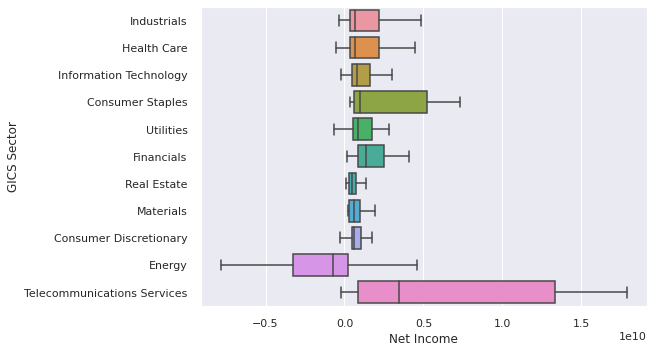

In [ ]:
sns.boxplot(
    data=data,
    y='GICS Sector',
    x='Net Income',
    showfliers=False);

Net income is generally positive. However, the energy sector seems to report largely negative net incomes!

In [ ]:
energy_df=(pd.DataFrame(
    data.query("`GICS Sector`=='Energy'")['GICS Sub Industry'].value_counts())
    .rename(columns={'GICS Sub Industry':'no_records'}))
energy_df['mean_net_income']=(
    data
    .query("`GICS Sector`=='Energy'")
    .groupby('GICS Sub Industry')['Net Income']
    .mean())
energy_df

,no_records,mean_net_income
Oil & Gas Exploration & Production,16,-4.562624e+09
Oil & Gas Refining & Marketing & Transportation,6,2.176333e+09
Integrated Oil & Gas,5,1.450334e+08
Oil & Gas Equipment & Services,3,-1.135667e+09


Looking closer, we find that one sub-industry is to blame: Oil & Gas Exploration & Production. This sub-industry has a very negative mean net income and by far the most records. Therefore this sub-industry outweighs the others and drags the distribution down into the negative net income range.

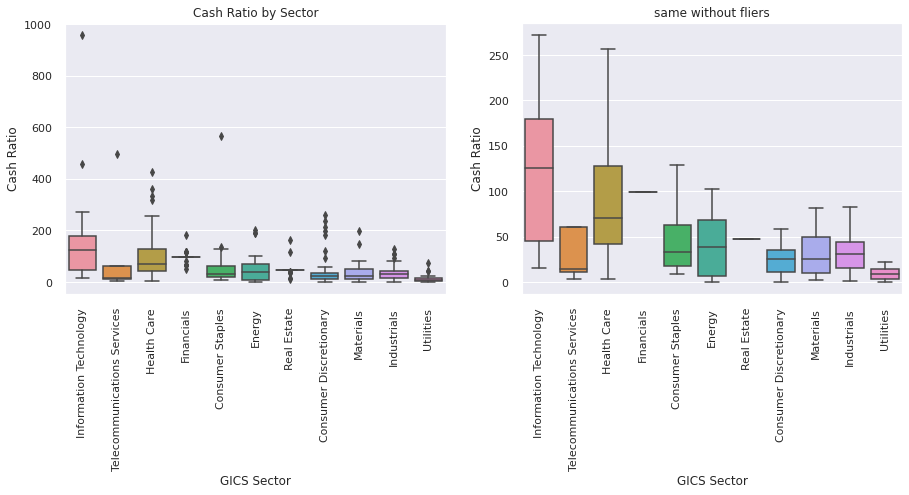

In [ ]:
# cash ratio boxplots
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Cash Ratio by Sector')
sns.boxplot(
    data=data,
    x='GICS Sector',
    y='Cash Ratio',
    order=(data
           .groupby('GICS Sector')['Cash Ratio']
           .mean()
           .sort_values(ascending=False)
           .index),
    showfliers=True)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
plt.title('same without fliers')
sns.boxplot(
    data=data,
    x='GICS Sector',
    y='Cash Ratio',
    order=(data
           .groupby('GICS Sector')['Cash Ratio']
           .mean()
           .sort_values(ascending=False)
           .index),
    showfliers=False)
plt.xticks(rotation=90)

plt.show()

Here we see the cash ratio by GICS sector. The sectors are sorted by mean cash ratio, with IT highest and utilities lowest.

We get a better idea of relative spread without the fliers, although it is precisely those that bias the means. Put another way, that value around 1000 is part of the reason IT has the highest mean cash ratio.

Financials and real estate are very tightly distributed. IT and health care, on the other hand, see a broad range in cash ratios. Utilities has a reliably low cash ratio. In the middle is consumer staples and energy. The former has a greater overall spread, but a narrower 50% than the latter.

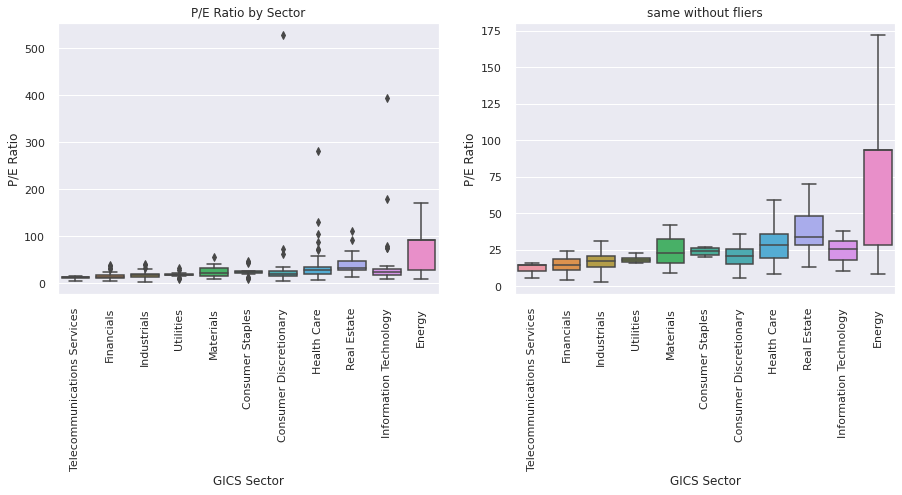

In [ ]:
# p/e ratio boxplots
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('P/E Ratio by Sector')
sns.boxplot(
    data=data,
    x='GICS Sector',
    y='P/E Ratio',
    order=(data
           .groupby('GICS Sector')['P/E Ratio']
           .mean()
           .sort_values(ascending=True)
           .index),
    showfliers=True)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
plt.title('same without fliers')
sns.boxplot(
    data=data,
    x='GICS Sector',
    y='P/E Ratio',
    order=(data
           .groupby('GICS Sector')['P/E Ratio']
           .mean()
           .sort_values(ascending=True)
           .index),
    showfliers=False)
plt.xticks(rotation=90)

plt.show()

Here are P/E ratios by sector, sorted by sector mean. A lower P/E ratio is generally considered better, as a high ratio indicates an overvalued stock.
* Telecom has the lowest P/E ratio.
* Energy has the highest P/E ratio and the greatest variablity from the lower fence to the upper fence.
* Consumer discretionary has one value far above the others. IT and health care also have a value floating far outside their range.
* Utilities has P/E ratios packed between roughly 20 and 25. This range is favored by many investors because it is not too high and still realistic. Financials and industrials also have P/E ratios on the lower end, though with greater spreads.

## Data Preprocessing

In [ ]:
data.duplicated().sum()

0

There are no duplicate records in our data set.

In [ ]:
data.isna().sum()

Ticker Symbol                   0
Security                        0
GICS Sector                     0
GICS Sub Industry               0
Current Price                   0
Price Change                    0
Volatility                      0
ROE                             0
Cash Ratio                      0
Net Cash Flow                   0
Net Income                      0
Earnings Per Share              0
Estimated Shares Outstanding    0
P/E Ratio                       0
P/B Ratio                       0
dtype: int64

Additionally, there are no records will null entries.

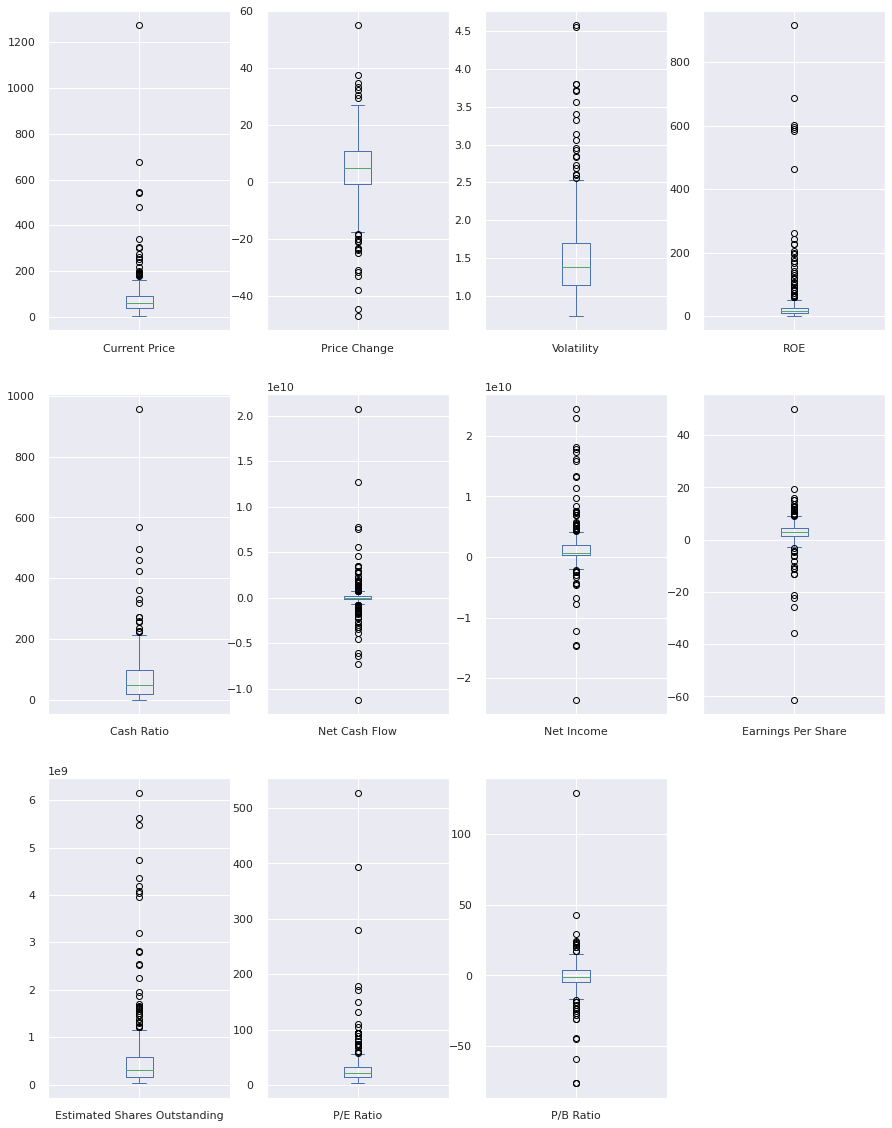

In [ ]:
data.plot(
    kind='box',
    subplots=True,
    sharey=False,
    layout=(3,4),
    figsize=(15,20));

We recall the boxplots from the EDA above to check for conspicuous outliers. The attributes Current Price, Cash Ratio, and P/B Ratio have prominent values on the high end.

In [ ]:
data.query('`Current Price`>1000')

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
243,PCLN,Priceline.com Inc,Consumer Discretionary,Internet & Direct Marketing Retail,1274.949951,3.190527,1.26834,29,184,-1671386000,2551360000,50.09,50935516.07,25.453183,-1.052429


Researching the market history of this security reveals that the recorded current price, while higher than our other observations, is completely reasonable. (Note: PCLN is now being traded on the Nasdaq under the ticker symbol BKNG.)

In [ ]:
data.query('`Cash Ratio`>800')

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
125,FB,Facebook,Information Technology,Internet Software & Services,104.660004,16.22432,1.320606,8,958,592000000,3669000000,1.31,2.800763e+09,79.893133,5.884467


A cash ratio of 958 is preposterous. [Research](https://www.macrotrends.net/stocks/charts/META/meta-platforms/current-ratio) indicates that Facebook's cash ratio has never risen above 14. As of now (January 2023), it's max was achieved in Q3-2017 at a value of just over 13. Facebooks's [current cash ratio](https://www.investing.com/equities/facebook-inc-ratios) is 2.57.

That being said, around 50% of our data have a cash ratio above 50, far outside the expectation of a data set of this size. We must conclude that there is a difference in definition or a systematic difference in the calculation which inflates all the cash ratios. As we will be scaling this data, the relationship between the records is far more important than the raw numbers, and we must look past this inconsistency.

In [ ]:
data.query('`P/B Ratio`>100')

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
6,ADS,Alliance Data Systems,Information Technology,Data Processing & Outsourced Services,276.570007,6.189286,1.116976,30,25,90885000,596541000,8.91,66951851.85,31.040405,129.064585


While ADS currently sees a P/B ratio far lower than the recorded value, its stock price history indicates there was a time when a ratio of 129 was possible.

In [ ]:
# scale numerical data
attr=data.drop(
    data.select_dtypes('object').columns,
    axis=1
).apply(zscore)

Lastly we separate out the numerical features and scale each column.

## Second EDA

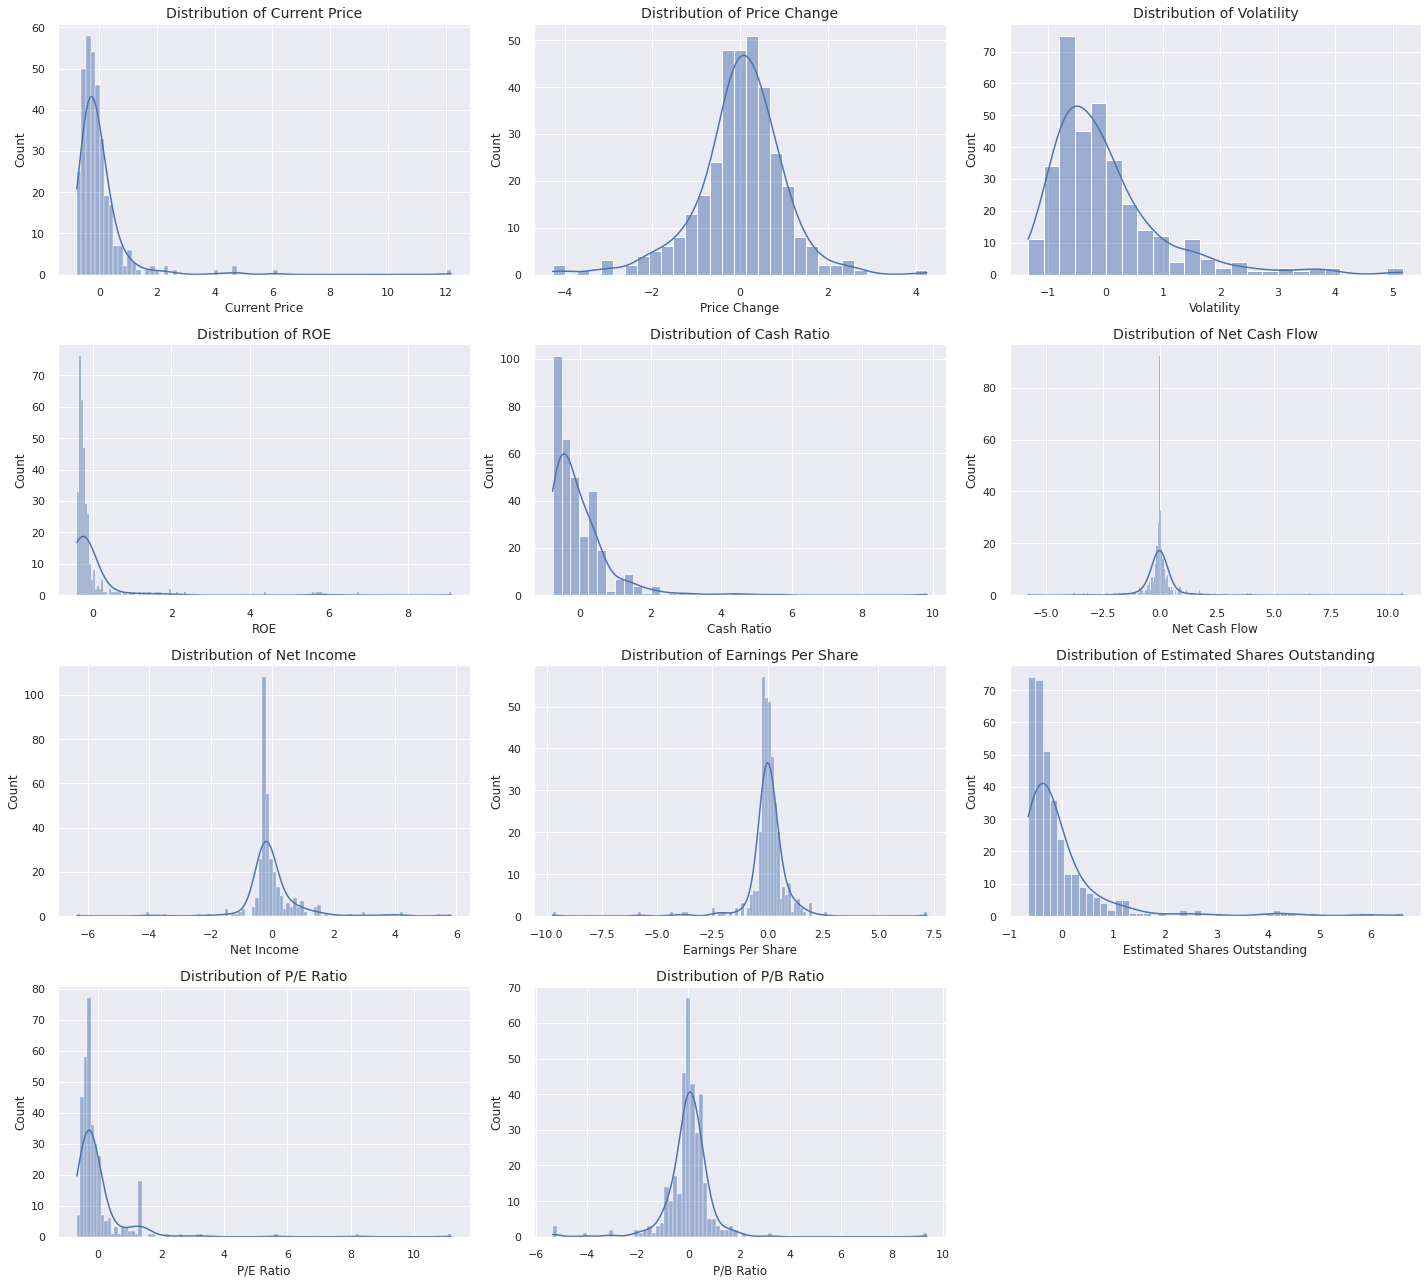

In [ ]:
plt.figure(figsize=(20,18))
for idx,col in enumerate(attr.columns):
  plt.subplot(4,3,idx+1)
  plt.title('Distribution of '+str(col),fontsize=14)
  sns.histplot(attr[col],kde=True)
plt.tight_layout()

As we only scaled the data, there is no change to the distributions other than the axis scales. Note that each distribution has a mean centered at 0 and a standard deviation of 1. This is especially apparent in the distribution of price change, which is approximately normal.

## K-means Clustering

### Exploration of k values

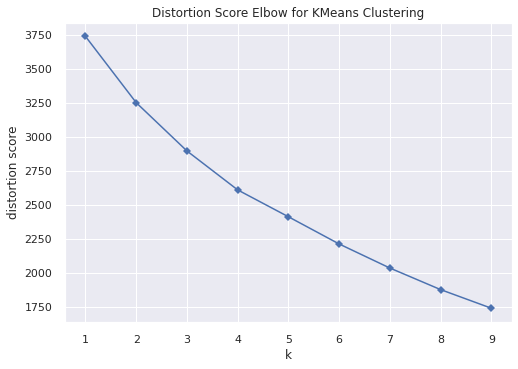

In [ ]:
# elbow method visualization
km=KMeans(n_init=10,random_state=1)
vis=KElbowVisualizer(km,k=(1,10),timings=False,locate_elbow=False)

vis.fit(attr)
vis.show();

The curve is fairly smooth, but k=3 and k=4 have slightly more bend than the rest in my estimation. 

In [ ]:
# compute silhouette scores
scores=[]
for k in range(2,10):
  scores.append(silhouette_score(
      attr,
      KMeans(n_clusters=k,
             n_init=10,
             random_state=1).fit_predict(attr)
  ))

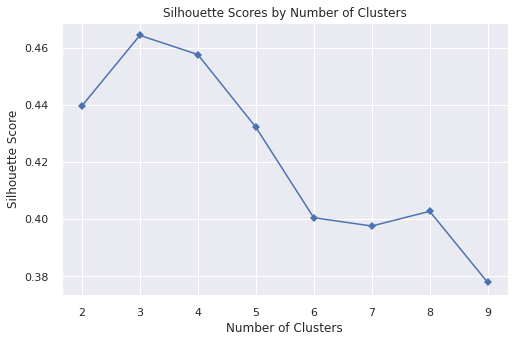

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Silhouette Scores by Number of Clusters')
plt.plot(np.arange(2,10),scores,marker='D')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

Looking at the silhouette scores for various numbers of clusters, we see the greatest score is achieved at k=3 clusters. After k=4, the values drop off sharply. At k=8, there is a brief rise.

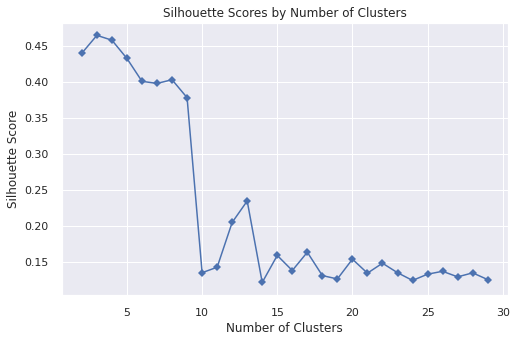

In [ ]:
# broad search silhouette
scores=[]
for k in range(2,30):
  scores.append(silhouette_score(
      attr,
      KMeans(n_clusters=k,
             n_init=10,
             random_state=1).fit_predict(attr)
  ))

plt.figure(figsize=(8,5))
plt.title('Silhouette Scores by Number of Clusters')
plt.plot(np.arange(2,30),scores,marker='D')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

Although k=8 looked appreciably worse than k=3 in the last plot, this broad search reveals that the scores for k<10 are all quite good. Interestingly, there's a spike around k=13.

To determine the best value for k, we will use the silhouette visualizer to study the quality of clusters.

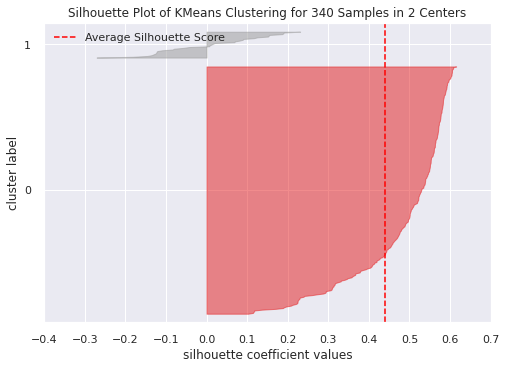

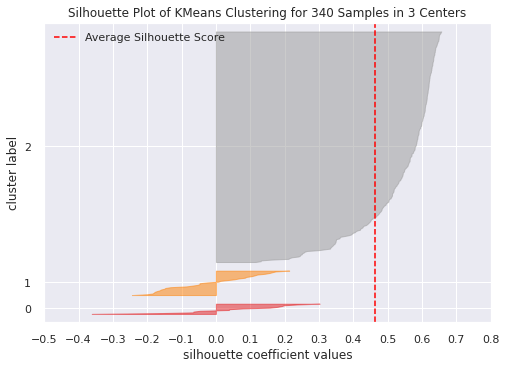

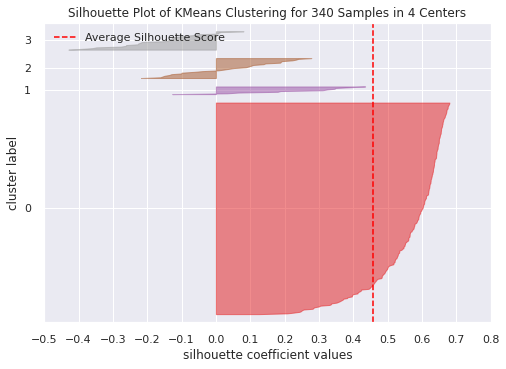

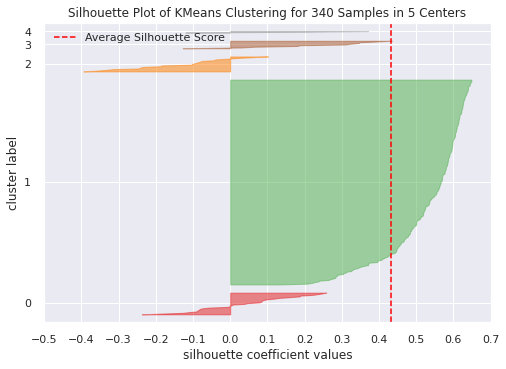

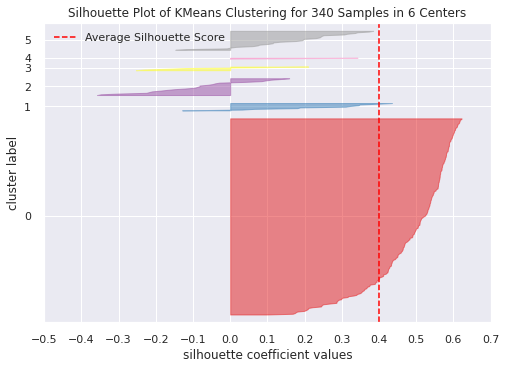

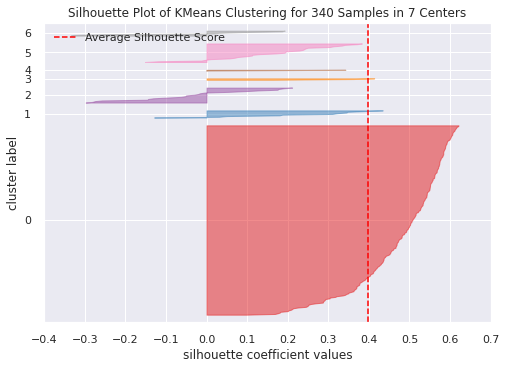

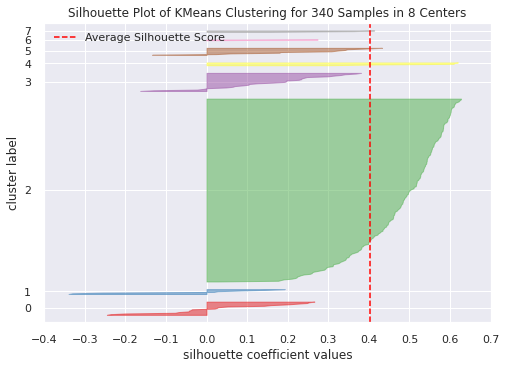

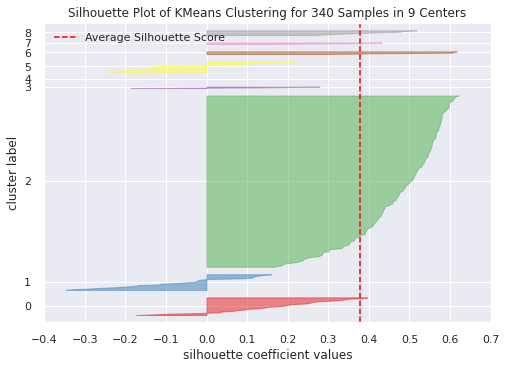

In [ ]:
# silhouette visualizer
for k in range(2,10):
  vis=SilhouetteVisualizer(
    KMeans(n_clusters=k,
           n_init=10,
           random_state=1)).fit(attr).show();

The visualizer yields some interesting findings.

* There is always one big group. This big group comprises observations with positive silhouette scores.
* The smaller groups are largely composed of entries with negative silhouette scores.
* Groups 0 and 1 in the k=3 model have just as many negative silhouette scores as positive ones. What's more, the worst (most negative) values in group 0 are greater in magnitude than the best (most positive) ones.
* The model which appears to have the fewest negative observations is k=8. Over 50% of records in each cluster have a positive silhouette score.
* The number of records in each of the smaller clusters varies. (See bar widths.)

In [ ]:
scores[3-2]-scores[8-2]

0.06165654778343571

Despite its slightly higher silhouette score, k=3 appears to be the weaker choice: The largest cluster's separation from the others is inflating the silhouette score, like skewed data biasing a mean higher than the median. What's more, the difference between scores for k=3 and k=8 is only 0.0617.

From the silhouette visualizer, we see that the best separation is achieved at k=8 clusters. Many of the clusters boast only records with positive silhouette scores, and negative scores do not comprise the majority of any cluster. We will further investigate k=8.

### k=8

In [ ]:
# kmeans model
km=KMeans(n_clusters=8,
          n_init=10,
          random_state=1)
km.fit(attr)
km_group=km.predict(attr)
data['km_group']=km_group

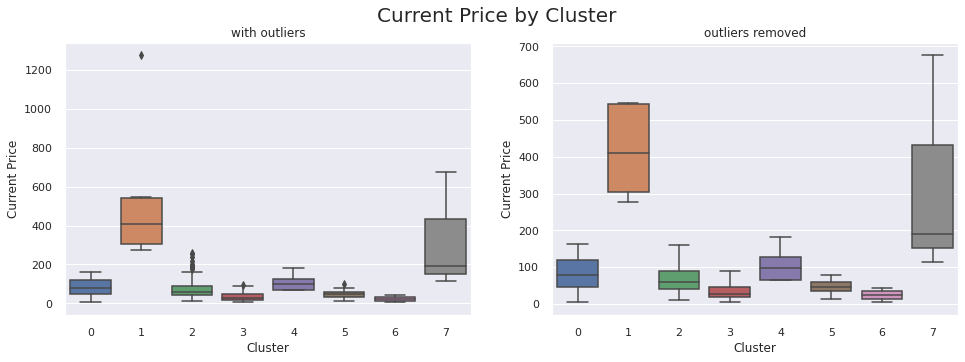

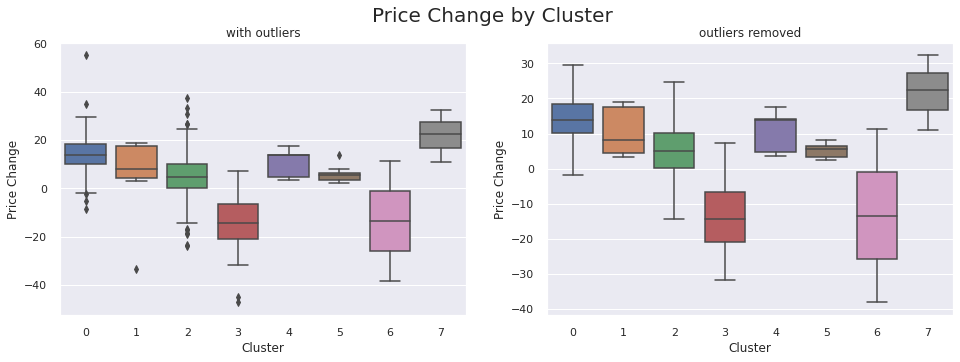

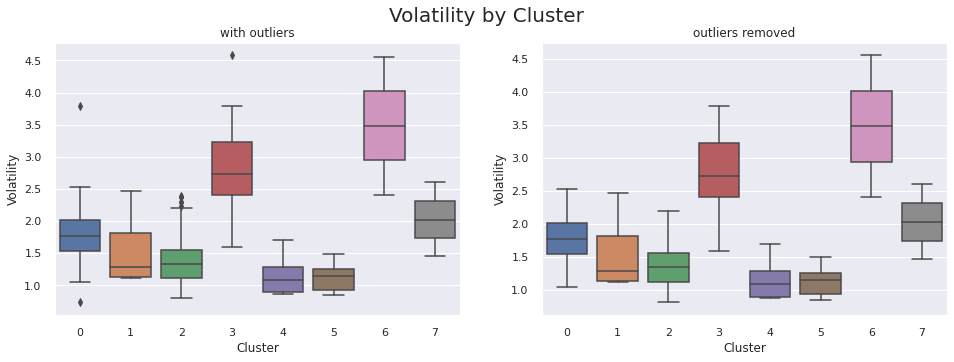

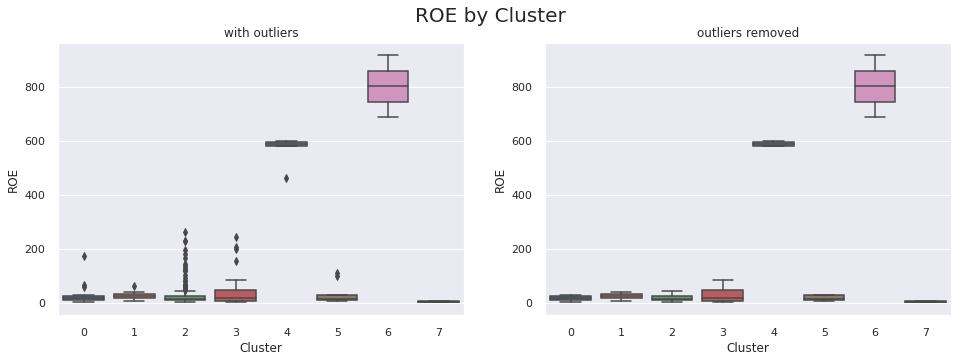

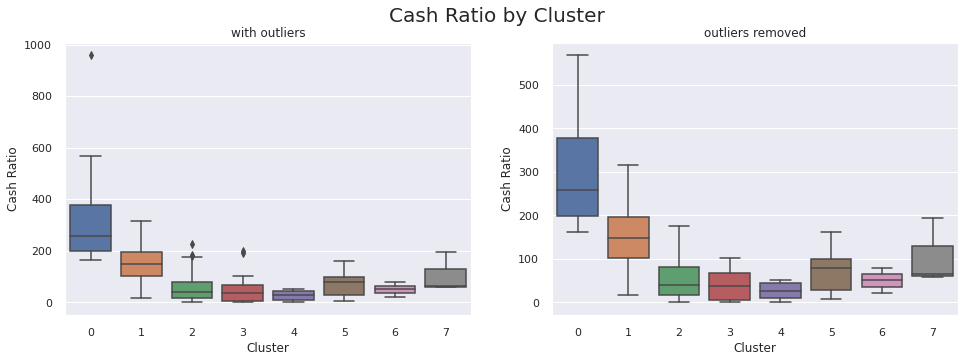

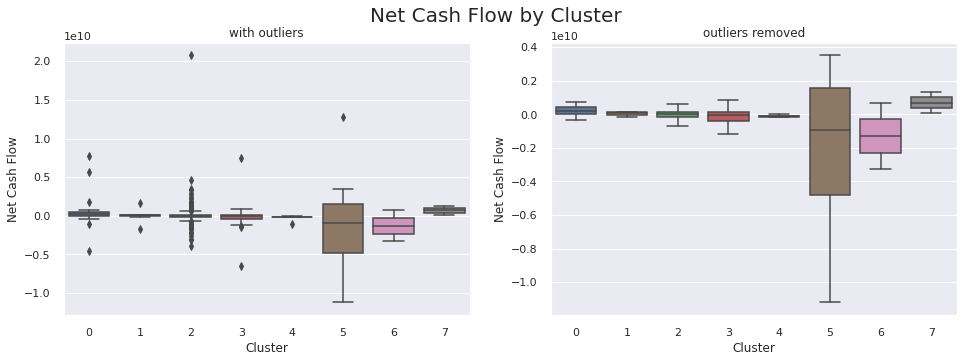

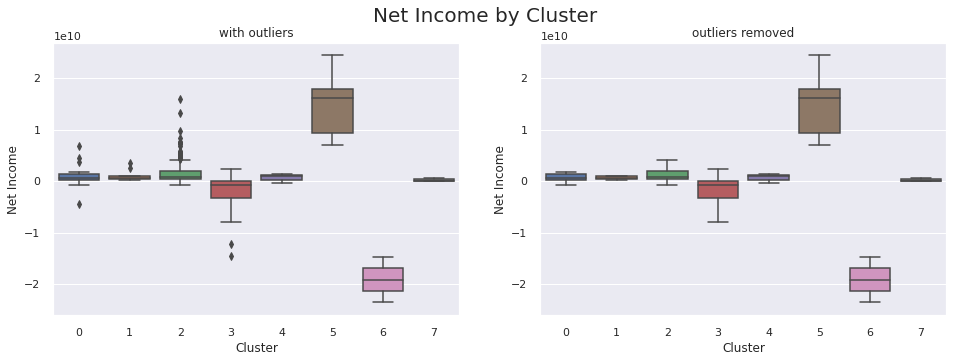

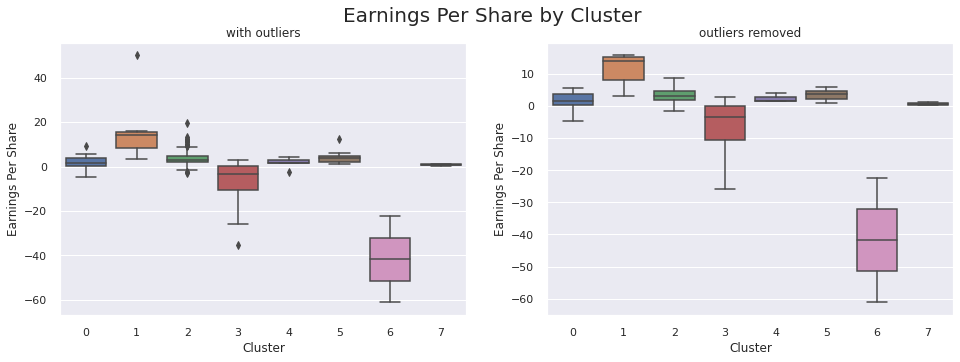

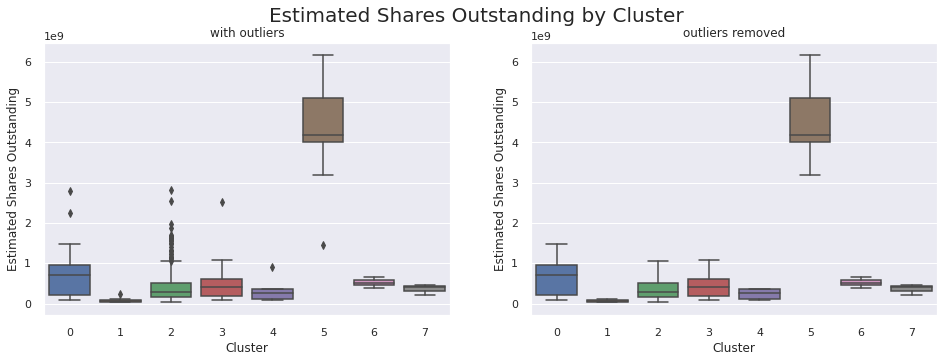

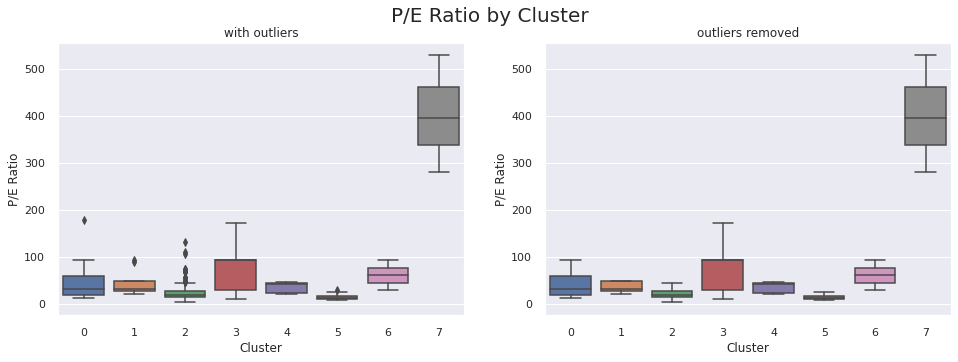

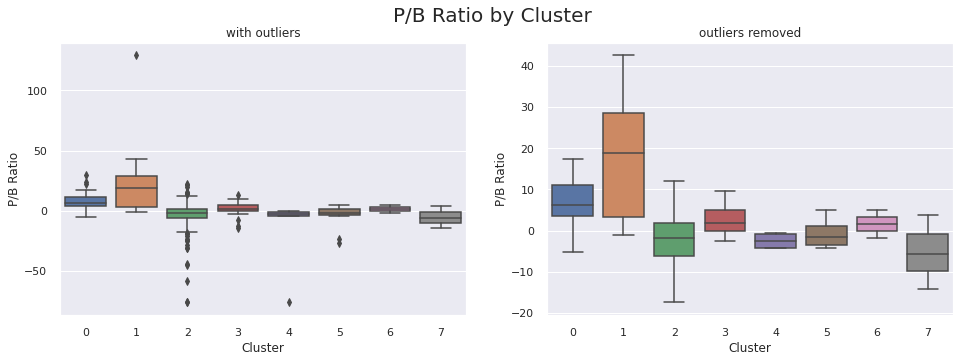

In [ ]:
# boxplots of groups
for col in attr.columns:
  plt.figure(figsize=(16,5))
  plt.suptitle(str(col)+' by Cluster',fontsize=20)
  plt.subplot(1,2,1)
  plt.title('with outliers')
  sns.boxplot(data=data,
              x='km_group',
              y=col,
              showfliers=True)
  plt.xlabel('Cluster')

  plt.subplot(1,2,2)
  plt.title('outliers removed')
  sns.boxplot(data=data,
              x='km_group',
              y=col,
              showfliers=False)
  plt.xlabel('Cluster')
  
  plt.show()
  print('')

In [ ]:
data.groupby('km_group').mean()

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
km_group,,,,,,,,,,,
0,80.152167,14.571437,1.829679,28.100000,321.850000,6.259290e+08,9.420505e+08,2.010500,7.904563e+08,45.067457,8.307945
1,508.534992,5.732177,1.504640,27.250000,150.875000,3.789588e+07,1.116994e+09,15.965000,7.565442e+07,43.727459,29.581664
2,71.100057,4.970680,1.372796,24.988636,51.087121,8.793073e+07,1.579776e+09,3.688466,4.356775e+08,23.232454,-3.350613
3,34.231808,-15.515565,2.832069,48.037037,47.740741,-1.286515e+08,-2.444319e+09,-6.284444,5.030315e+08,75.627265,1.655990
4,108.304002,10.737770,1.165694,566.200000,26.600000,-2.787600e+08,6.871800e+08,1.548000,3.496071e+08,34.898915,-16.851358
5,50.517273,5.747586,1.130399,31.090909,75.909091,-1.072273e+09,1.483309e+10,4.154545,4.298827e+09,14.803577,-4.552119
6,24.485001,-13.351992,3.482611,802.000000,51.000000,-1.292500e+09,-1.910650e+10,-41.815000,5.195740e+08,60.748608,1.565141
7,327.006671,21.917380,2.029752,4.000000,106.000000,6.982407e+08,2.875470e+08,0.750000,3.667632e+08,400.989188,-5.322376


### Cluster Analysis

There's a lot to absorb here, but let's start by highlighting group 5. 

* The current stock prices for securities in group 5 are comparable to some other groups, but are generally on the lower end.
* Price change is low but positive, with a narrow spread in variability. Low volatility means that this group contains fairly consistent securities.
* Net cash flow is more variable here than in any other group. Perhaps this is biased by several negative records. Do note that there is also a highly positive record, but this is so far outside the spread of the data that it is represented as a singular dot above the upper fence of the boxplot.
* Net income of group 5 securities is higher than any other group!
* This group has the second-highest mean earnings per share, being outperformed by group 1.
* Very noticeably, group 5 has more shares outstanding than any other.
* Group 5 also has some of the lowest P/E ratios, indicating that the stock price is not inflated relative to the company's performance. (Note that this group has the lowest mean P/E ratio.)

Let's take a closer look at the securities comprising group 5.

In [ ]:
data.query('km_group==5')

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,km_group
52,C,Citigroup Inc.,Financials,Banks,51.750000,4.714695,1.261984,8,99,-11208000000,17242000000,5.41,3.187061e+09,9.565619,-1.167533,5
123,F,Ford Motor,Consumer Discretionary,Automobile Manufacturers,14.090000,2.398256,1.151454,26,43,3515000000,7373000000,1.86,3.963978e+09,7.575269,5.108756,5
140,GILD,Gilead Sciences,Health Care,Biotechnology,101.190002,2.689264,1.494060,98,148,2824000000,18108000000,12.37,1.463864e+09,8.180275,3.159446,5
167,INTC,Intel Corp.,Information Technology,Semiconductors,34.450001,14.035095,1.226022,19,162,12747000000,11420000000,2.41,4.738589e+09,14.294606,3.954975,5
177,JPM,JPMorgan Chase & Co.,Financials,Banks,66.029999,8.033377,1.130337,10,99,-7341000000,24442000000,6.05,4.040000e+09,10.914049,-1.886881,5
181,KO,Coca Cola Company,Consumer Staples,Soft Drinks,42.959999,6.812526,0.889913,29,74,-1649000000,7351000000,1.69,4.349704e+09,25.420118,-1.466307,5
246,PFE,Pfizer Inc.,Health Care,Pharmaceuticals,32.279999,3.130991,1.238748,11,79,298000000,6960000000,1.13,6.159292e+09,28.566371,-4.213309,5
287,T,AT&T Inc,Telecommunications Services,Integrated Telecommunications Services,34.410000,5.942118,0.859442,11,11,-3482000000,13345000000,2.37,5.630802e+09,14.518987,-23.537323,5
317,VZ,Verizon Communications,Telecommunications Services,Integrated Telecommunications Services,46.220001,6.277303,0.842592,109,14,-6128000000,17879000000,4.38,4.081963e+09,10.552512,-26.380687,5
320,WFC,Wells Fargo,Financials,Banks,54.360001,5.532912,0.969774,12,99,-460000000,22894000000,4.18,5.477033e+09,13.004785,-0.938007,5


We find primarily big-name, multi-national corporations here, including financial institutions, major technology and telecommunication corporations, and even common consumer brands such as Ford and Coca Cola. Note that banks are the major contributor to the negative skew in net cash flow.

Turning to a more geneal cluster analysis, let's look at the number of records in each group.

In [ ]:
data['km_group'].value_counts()

2    264
3     27
0     20
5     11
1      8
4      5
7      3
6      2
Name: km_group, dtype: int64

As suggested by the silhouette visualizer, there is one big group (namely group 2) and many smaller groups. Group 6 has two records, the fewest in the bunch.

In [ ]:
# group 2
data.query('km_group==2')['GICS Sector'].value_counts()

Industrials                    50
Financials                     45
Consumer Discretionary         32
Health Care                    28
Real Estate                    26
Utilities                      24
Information Technology         20
Materials                      17
Consumer Staples               15
Energy                          5
Telecommunications Services     2
Name: GICS Sector, dtype: int64

Group 2 is comprised of securities from many sectors. Industrials are the most common, followed by financials. The sector with the fewest records in this group is telecom.

In [ ]:
# group 3
data.query('km_group==3')['GICS Sector'].value_counts()

Energy                    21
Industrials                2
Materials                  2
Information Technology     2
Name: GICS Sector, dtype: int64

In [ ]:
data['GICS Sector'].value_counts()['Energy']

30

Of the 30 Energy securities in our data set, 21 have landed in group 3.

In [ ]:
(data
 .query('km_group==3')
 .loc[(data
       .query('km_group==3')['GICS Sector']
       .mask(lambda x: x=='Energy')
       .notnull())
 ]
)

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,km_group
33,ARNC,Arconic Inc,Industrials,Aerospace & Defense,7.398807,1.647784,2.592065,3,37,42000000,-322000000,-0.31,1.038710e+09,18.687607,2.639814,3
127,FCX,Freeport-McMoran Cp & Gld,Materials,Copper,6.770000,-31.685167,3.796410,155,5,-240000000,-12156000000,-11.31,1.074801e+09,22.811951,2.935427,3
157,HPE,Hewlett Packard Enterprise,Information Technology,"Technology Hardware, Storage & Peripherals",15.200000,-17.837838,3.400491,7,45,7523000000,2461000000,1.80,5.139877e+08,25.309524,3.954975,3
213,MOS,The Mosaic Company,Materials,Fertilizers & Agricultural Chemicals,27.590000,-11.229086,2.830675,10,62,-1098300000,1000400000,2.79,3.585663e+08,9.888889,5.846617,3
259,PWR,Quanta Services Inc.,Industrials,Industrial Conglomerates,20.250000,-16.632362,2.954291,10,11,-61744000,321824000,1.59,2.024050e+08,12.735849,4.291894,3
289,TDC,Teradata Corp.,Information Technology,Application Software,26.420000,-8.833678,2.730659,25,88,5000000,-214000000,-1.53,1.398693e+08,74.555557,4.068084,3


The other entries in group 3 are split between industrials, materials, and information technology. These six records are shown above.

In [ ]:
# group 0
data.query('km_group==0')['GICS Sector'].value_counts()

Information Technology         8
Health Care                    5
Consumer Discretionary         3
Telecommunications Services    1
Energy                         1
Consumer Staples               1
Materials                      1
Name: GICS Sector, dtype: int64

Group 0 is comprised primarily of IT and healthcare securities. It generally performs around the middle of the pack, but it offers the highest cash ratios among the groups.

In [ ]:
data.query('km_group==6')

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,km_group
30,APA,Apache Corporation,Energy,Oil & Gas Exploration & Production,44.470001,11.397804,2.405408,917,80,698000000,-23528000000,-61.20,384444444.4,93.089287,4.970809,6
62,CHK,Chesapeake Energy,Energy,Integrated Oil & Gas,4.500000,-38.101788,4.559815,687,22,-3283000000,-14685000000,-22.43,654703522.1,28.407929,-1.840528,6


While group 6 is small, at least both records are from the energy sector. Other than that, their performance differs in almost every attribute.

### A Curiosity: k=3

We briefly investigate the possibility of only three clusters.

In [ ]:
# kmeans with k=3
km3=KMeans(n_clusters=3,
           n_init=10,
           random_state=1)
km3.fit(attr)
km_group3=km3.predict(attr)
data['km_group3']=km_group3

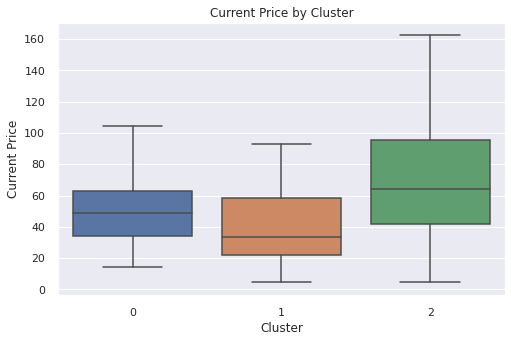

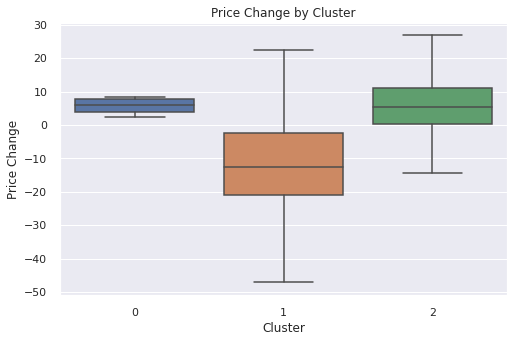

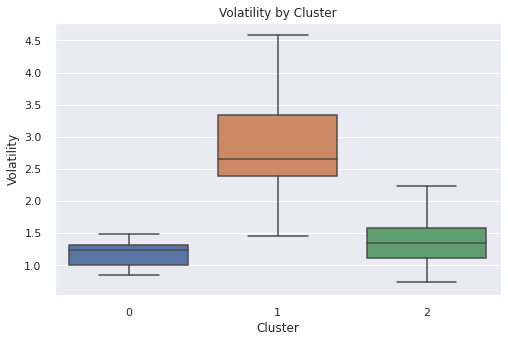

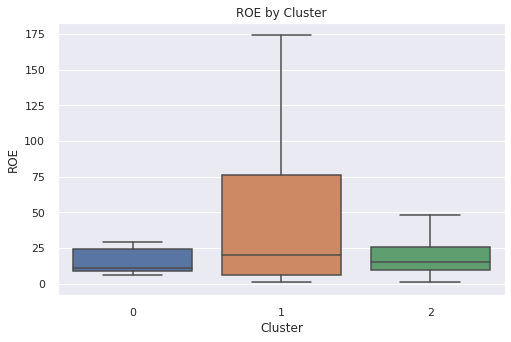

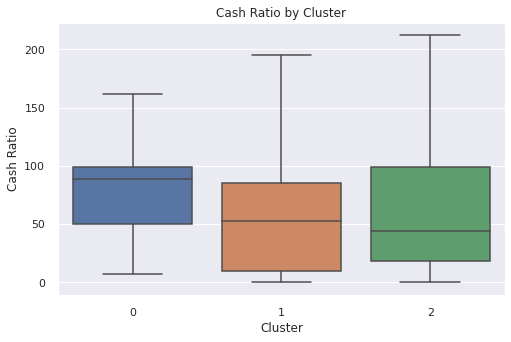

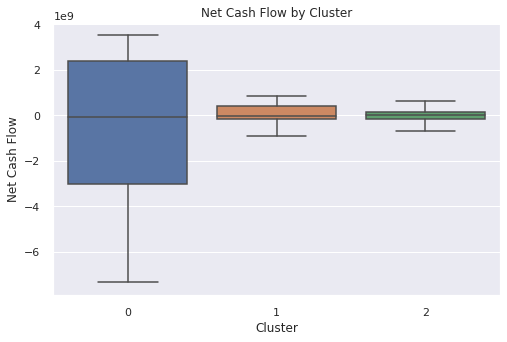

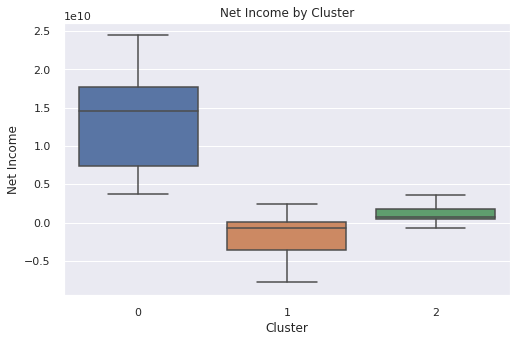

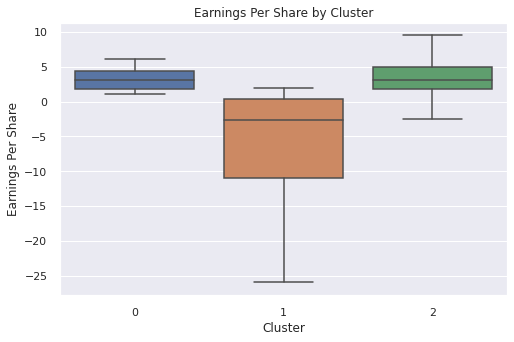

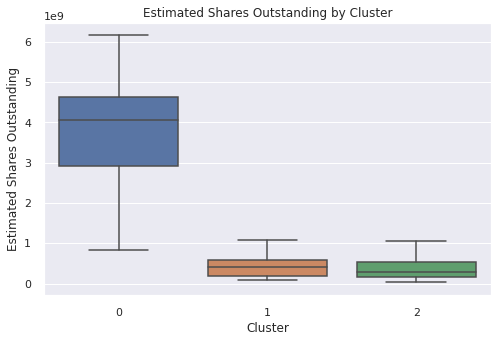

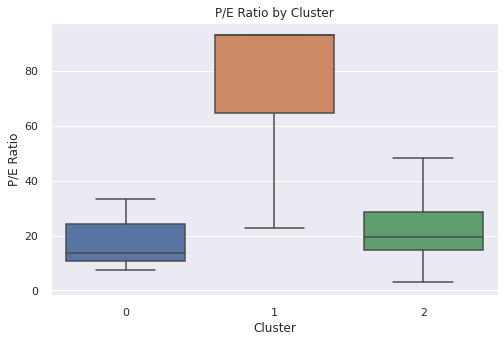

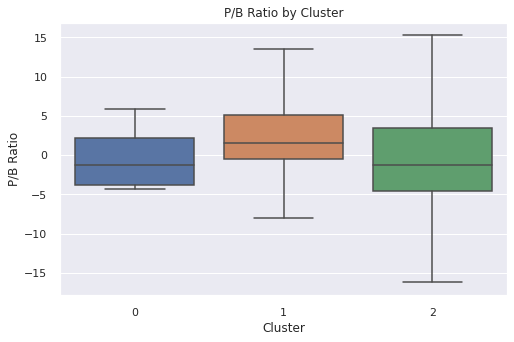

In [ ]:
for col in attr.columns:
  plt.figure(figsize=(8,5))
  plt.title(str(col)+' by Cluster')
  sns.boxplot(data=data,
              x='km_group3',
              y=col,
              showfliers=False)
  plt.xlabel('Cluster')
  plt.show()
  print('')

With only three clusters, we see some features with separation and others with none. This model seems too coarse to distinguish meaningfully between groups of securities.

## Hierarchical Clustering

### Exploration of linkage methods, distance metrics, and number of clusters

In [ ]:
# declaring variables
dist_metrics=['euclidean','chebyshev','mahalanobis','minkowski','cityblock']
link_methods=['single','average','complete','weighted']
pointwise=pdist(attr)

tab=pd.DataFrame(
    np.zeros((5,4)),
    index=dist_metrics,
    columns=link_methods)

max_coph=0
max_coph_data={'metric':'','linkage':''}

We will explore many distance metrics and linkage methods to identify the pair with the highest cophenet correlation.

In [ ]:
# computing cophenet scores
for d in dist_metrics:
  for l in link_methods:
    z=linkage(attr,metric=d,method=l)
    c,_=cophenet(z,pointwise)
    tab.loc[d,l]=c
    if c>max_coph:
      max_coph=c
      max_coph_data['metric']=d
      max_coph_data['linkage']=l

In [ ]:
print(f'''The maximum cophenetic correlation is {max_coph}
      with the {max_coph_data['metric']} metric and {max_coph_data['linkage']} linkage method.''')

The maximum cophenetic correlation is 0.9422540609560814
      with the euclidean metric and average linkage method.


In [ ]:
tab

,single,average,complete,weighted
euclidean,0.923227,0.942254,0.787328,0.869378
chebyshev,0.906254,0.933827,0.598891,0.912736
mahalanobis,0.925920,0.924732,0.792531,0.870832
minkowski,0.923227,0.942254,0.787328,0.869378
cityblock,0.933419,0.930215,0.737533,0.731046


The best score is achieved with the euclidean metric and average linkage. The table above lists the cophenet correlation for every pair of metric and linkage method.

Notice that the scores trend based on the linkage method, with distance metric having far less effect. For example, the complete linkage method reliably led to lower cophenet correlation across distance metrics.

There are a few extra linkage methods that require the Euclidean metric. Let's look at the dendrograms for all Euclidean linkage methods.

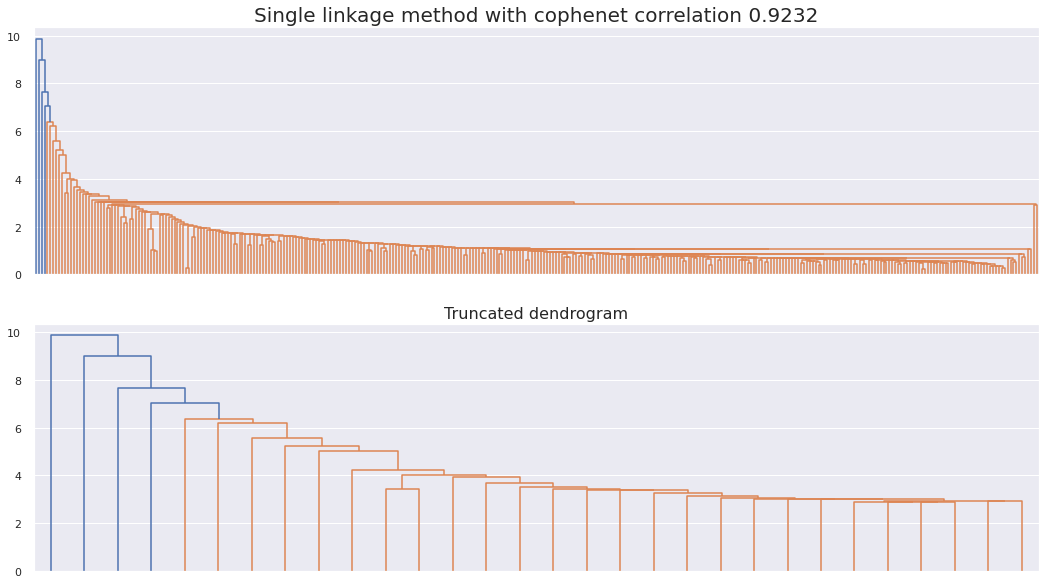

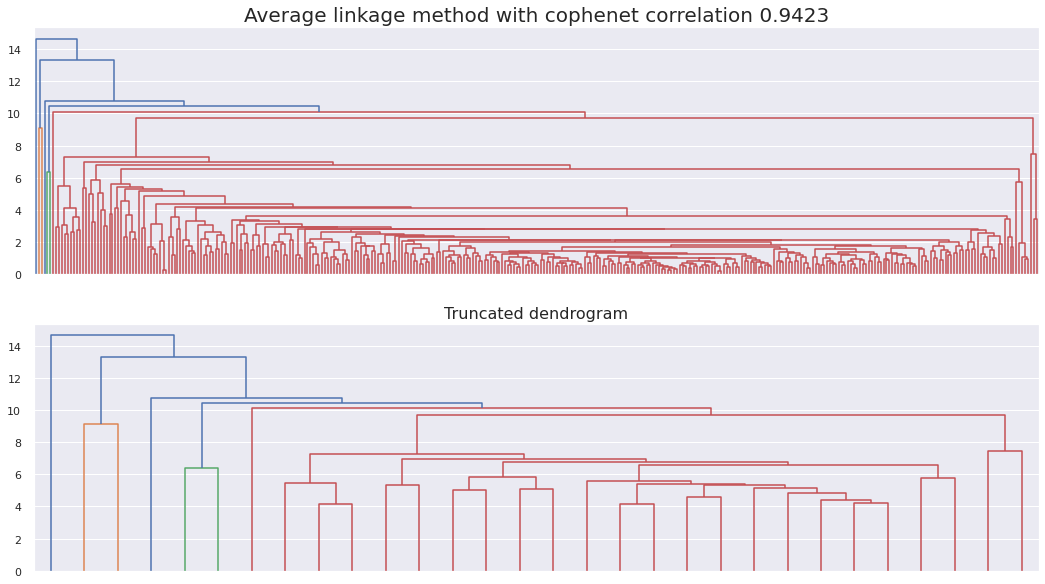

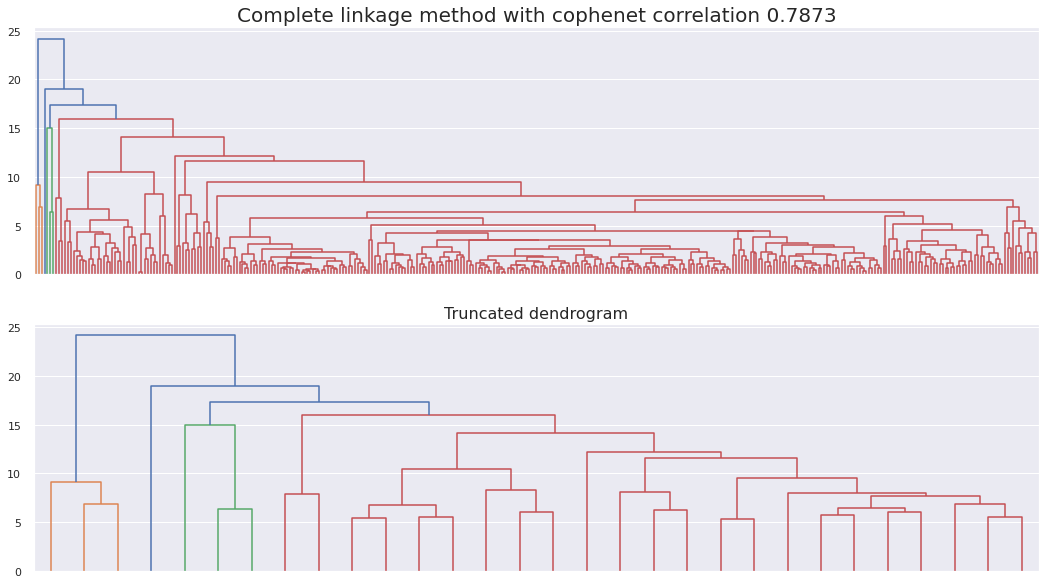

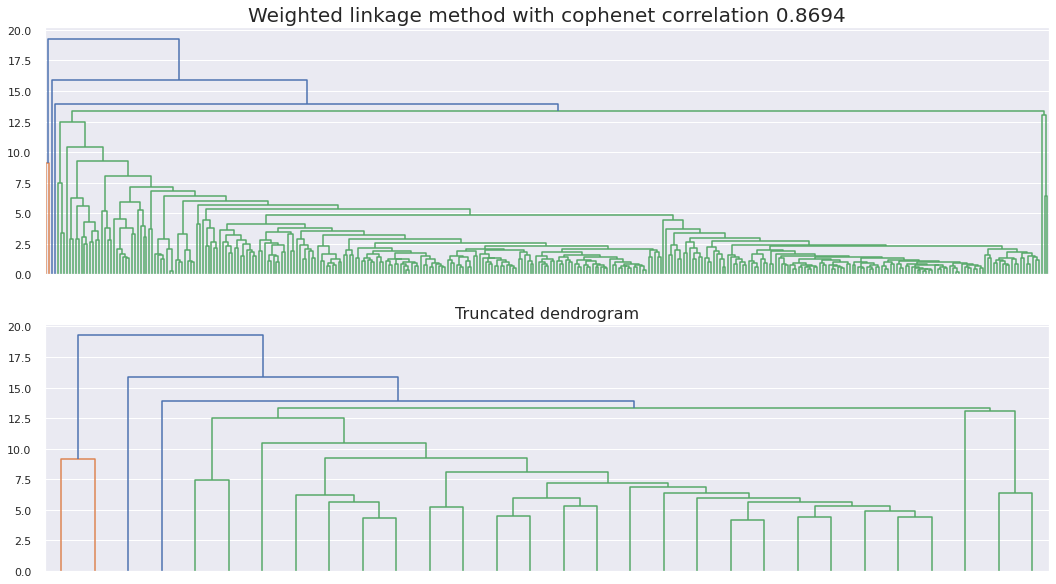

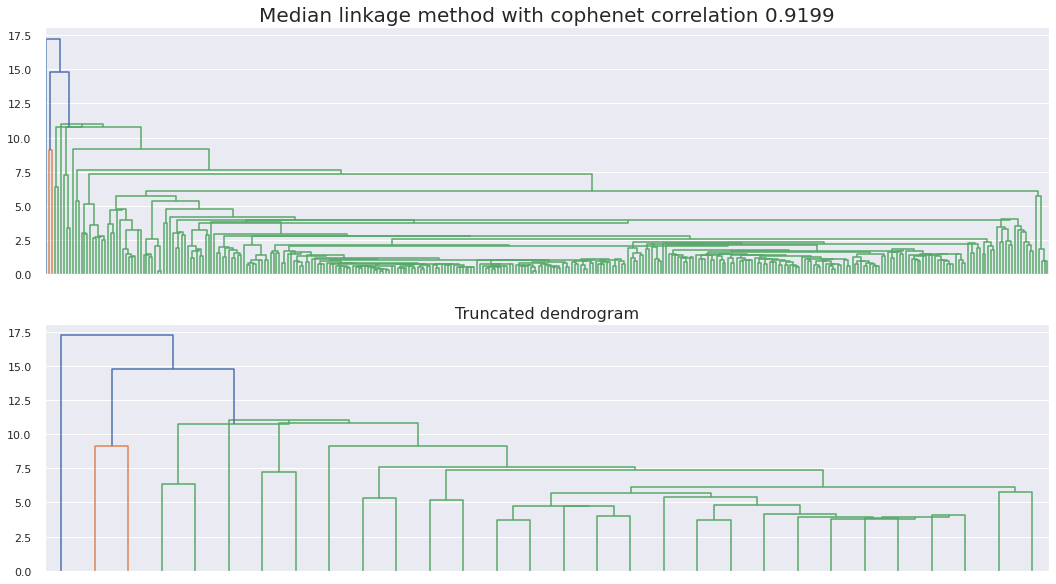

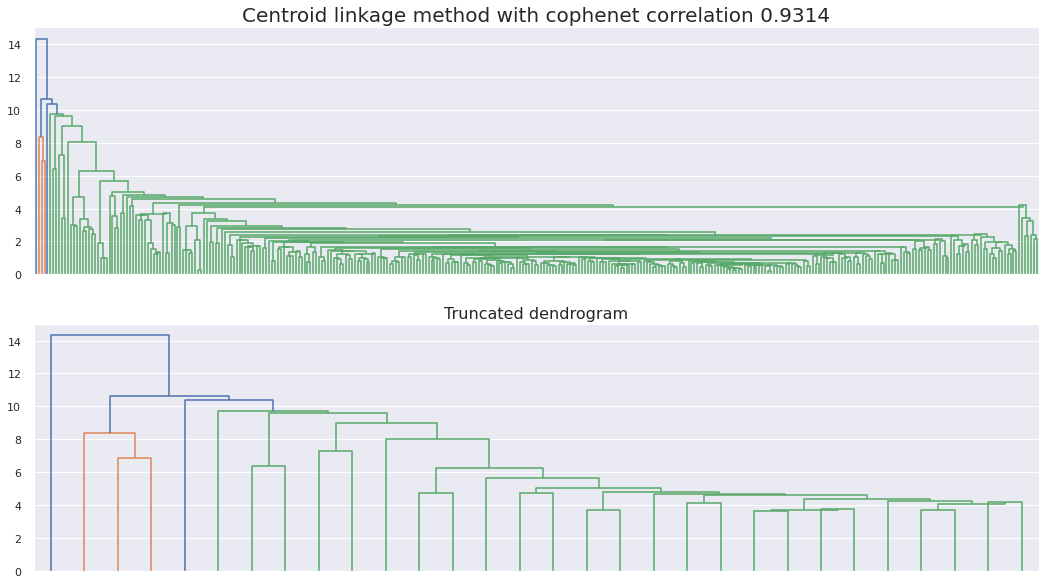

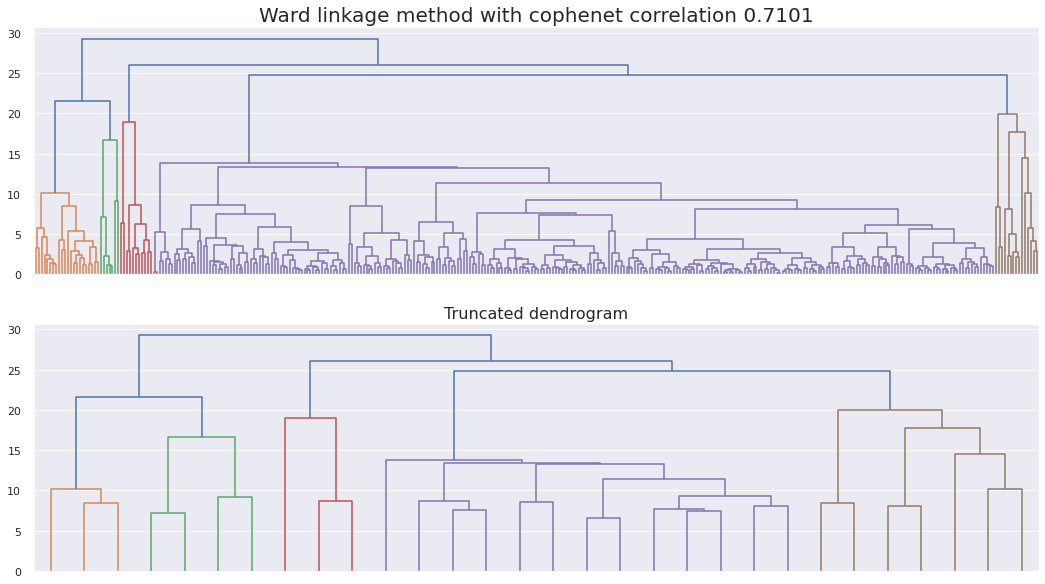

In [ ]:
link_methods=['single','average','complete','weighted','median','centroid','ward']

# dendrogram plots
for l in link_methods:
  z=linkage(attr,metric='euclidean',method=l)
  c,_=cophenet(z,pointwise)

  # full tree
  plt.figure(figsize=(18,10))
  plt.subplot(2,1,1)
  plt.title(f'{l.capitalize()} linkage method with cophenet correlation {np.round(c,4)}',
            fontsize=20)
  dendrogram(z)
  plt.xticks([])

  # truncated
  plt.subplot(2,1,2)
  plt.title('Truncated dendrogram',
            fontsize=16)
  dendrogram(z,p=30,truncate_mode='lastp')
  plt.xticks([])
  plt.show()
  print('')

The general clusterings for each method can be observed in the truncated dendrograms. These truncated plots more accurately represent how the clustering would look for our purposes, as we will definitely not choose a model with more than, say, twenty clusters.
* One of the most organized dendrogram is the single linkage. The hierarchies are quite clear here.
* The average linkage method still offers the best cophenet correlation, though centroid is a close second.
* The Ward method has the lowest cophenet correlation. Additionally, the dendrogram structure is noticably different from the rest.

Let's look closer at the dendrogram with Euclidean distance and average linkage.

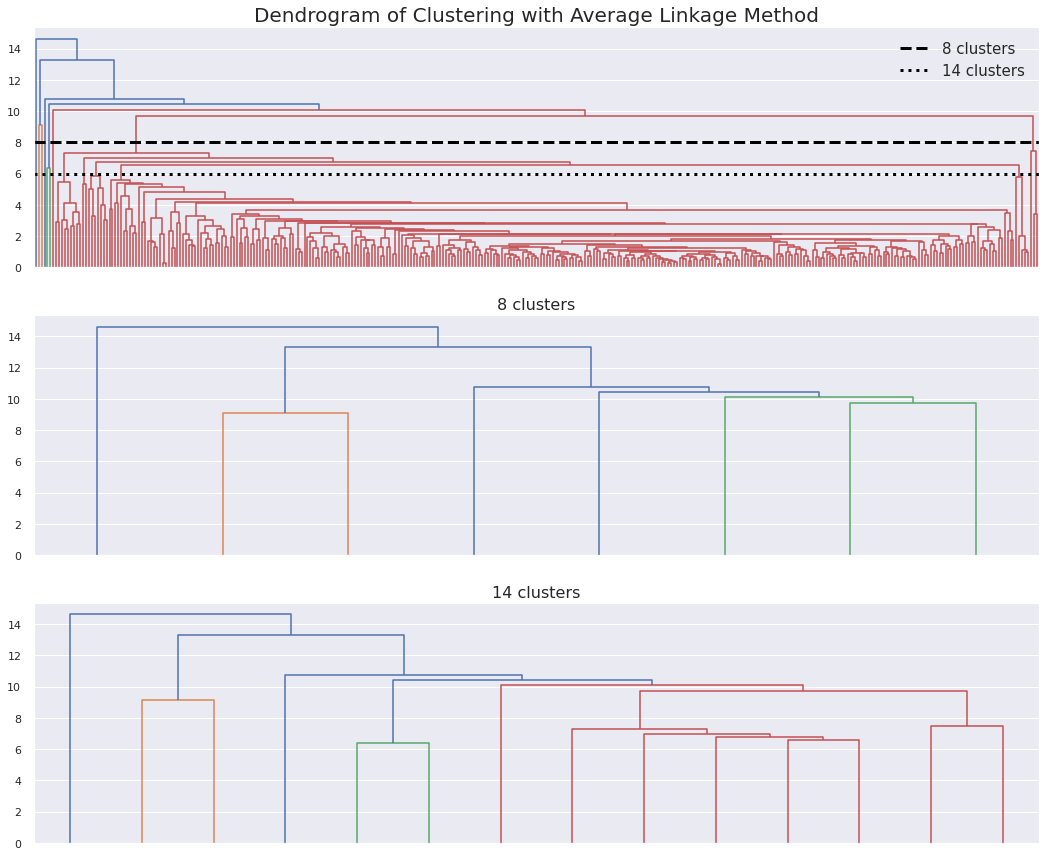

In [ ]:
z=linkage(attr,metric='euclidean',method='average')

plt.figure(figsize=(18,15))

# full dendrogram
plt.subplot(3,1,1)
plt.title('Dendrogram of Clustering with Average Linkage Method',fontsize=20)
dendrogram(z)
plt.axhline(y=8,
            color='black',
            linestyle='dashed',
            linewidth=3,
            label='8 clusters')
plt.axhline(y=6,
            color='black',
            linestyle='dotted',
            linewidth=3,
            label='14 clusters')
plt.xticks([])
plt.legend(loc='upper right',
           prop={'size':15})

# truncated 8
plt.subplot(3,1,2)
plt.title('8 clusters',fontsize=16)
dendrogram(z,p=8,truncate_mode='lastp')
plt.xticks([])

# truncated 14
plt.subplot(3,1,3)
plt.title('14 clusters',fontsize=16)
dendrogram(z,p=14,truncate_mode='lastp')
plt.xticks([])

plt.show()

### Comparing k values

We start with eight clusters.

In [ ]:
# 8 clusters
ag8=AgglomerativeClustering(n_clusters=8,
                            metric='euclidean',
                            linkage='average')
ag8.fit(attr)

pd.Series(ag8.labels_).value_counts()

2    330
0      3
1      2
5      1
7      1
6      1
3      1
4      1
dtype: int64

It seems that most records are sorted into a single group. Is this true of model with a different number of clusters?

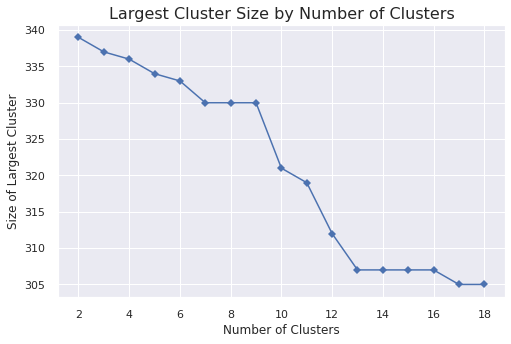

In [ ]:
# plot of biggest cluster size
cl_size=[]
for k in range(2,19):
  a=AgglomerativeClustering(
      n_clusters=k,
      metric='euclidean',
      linkage='average'
  ).fit(attr).labels_
  cl_size.append(
      pd.Series(a)
      .value_counts(sort=True)
      .reset_index(drop=True)[0])

plt.figure(figsize=(8,5))
plt.title('Largest Cluster Size by Number of Clusters',fontsize=16)
plt.plot(np.arange(2,19),cl_size,marker='D')
plt.xlabel('Number of Clusters')
plt.ylabel('Size of Largest Cluster');

At best, hierarchical clustering is throwing 90% of the data into one group, and usually even more. This problem persists for every reasonably small choice of k. That is to say, there can be very little in the way of trends in these groupings, as one group is too large and the rest are too small.

In [ ]:
# 14 clusters
ag14=AgglomerativeClustering(n_clusters=14,
                            metric='euclidean',
                            linkage='average')
ag14.fit(attr)

pd.Series(ag14.labels_).value_counts()

2     307
4       9
0       7
1       5
5       2
10      2
11      1
8       1
7       1
13      1
6       1
3       1
12      1
9       1
dtype: int64

Our other candidate, k=14, does not fare much better. About 90% of the data is sorted into one cluster. The majority of the other clusters are singleton sets or have two records. Let's look for trends in only the clusters with more.

In [ ]:
data['ag_group']=ag14.labels_

In [ ]:
# identifying somewhat bigger clusters
idx=[]
vc=pd.Series(ag14.labels_).value_counts().to_dict()
for key in vc.keys():
  if vc[key]>2:
    idx.append(key)

data_cut=data.query('ag_group in @idx')

We have cut out records from the data set that don't land in one of the four biggest clusters obtained by agglomerative clustering.

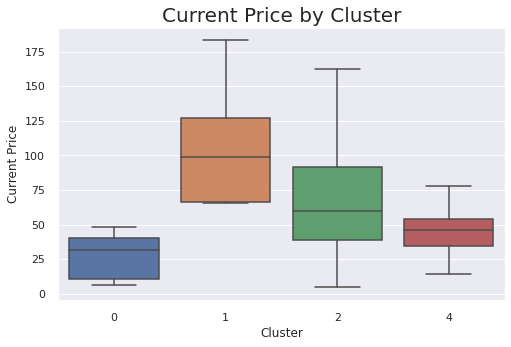

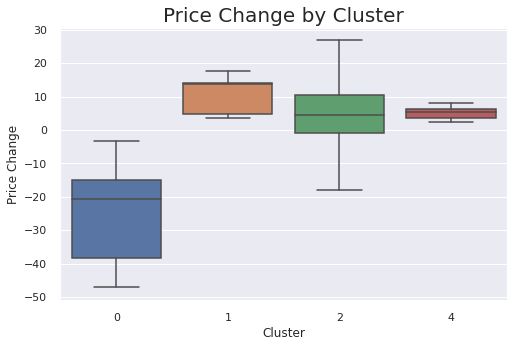

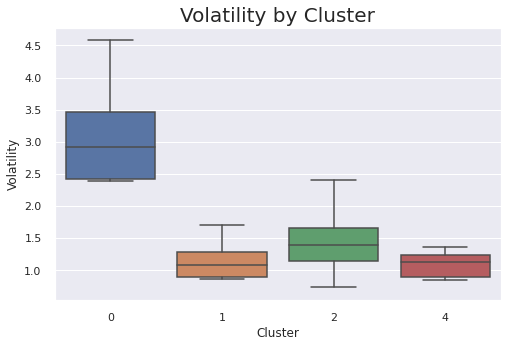

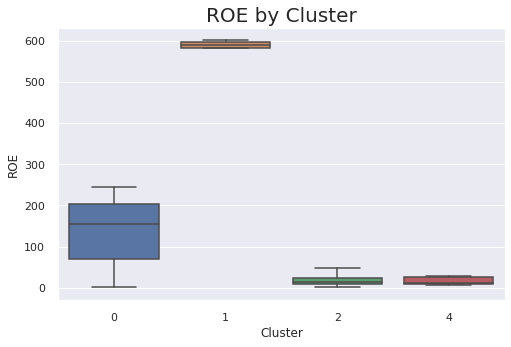

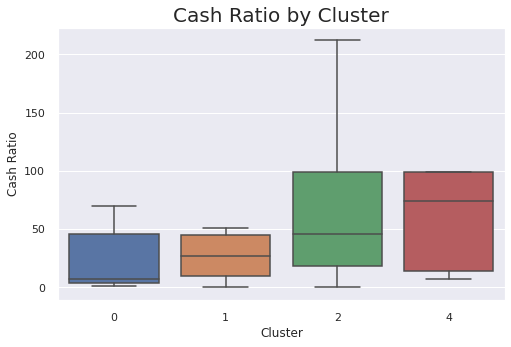

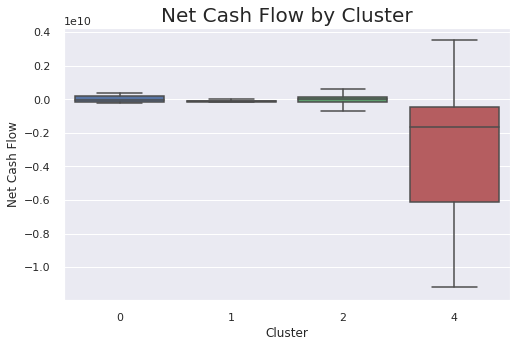

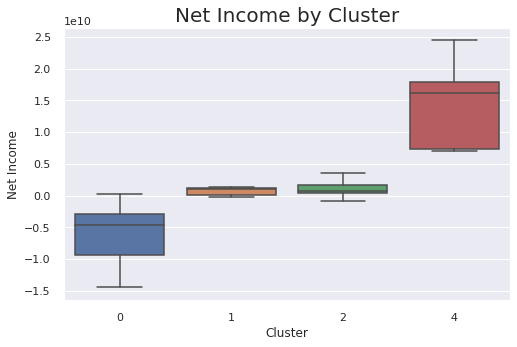

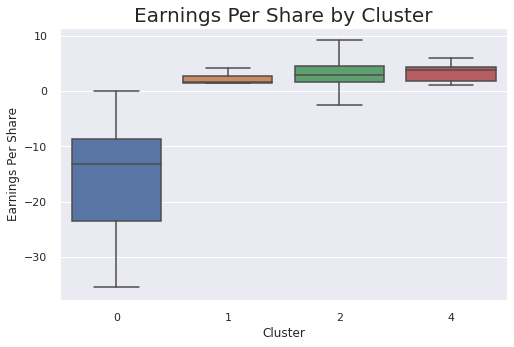

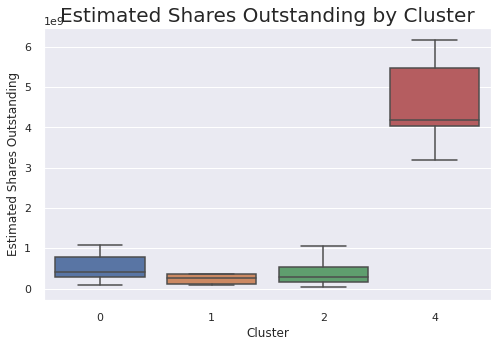

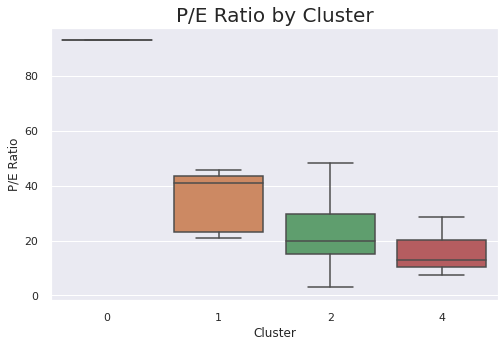

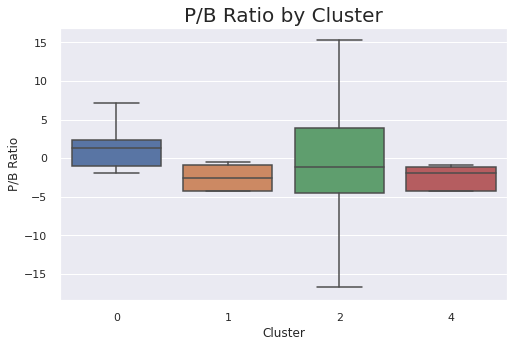

In [ ]:
# boxplots
for col in attr.columns:
  plt.figure(figsize=(8,5))
  plt.title(str(col)+' by Cluster',fontsize=20)
  sns.boxplot(data=data_cut.drop('km_group',axis=1),
              x='ag_group',
              y=col,
              showfliers=False)
  plt.xlabel('Cluster')
  plt.show()
  print('')

Recall that group 0 has 7 records, group 1 has 5 records, group 2 has 307 records, and group 4 has 9 records.

Looking at the top four clusters, we get meaningful trends and good separation of features.
* Group 0 generally has the lowest current price.
* Group 4 has an extremely narrow price change. Securities in group 4 very reliably gain value.
* On the other hand, group 0 has a wide spread of negative values, meaning that these lose value by varying amounts. In addition, group 0 is highly volitile, meaning the spread of the price change data over the last 13 weeks is greater.
* Group 1 outperforms the rest on ROE by a considerable margin.
* Cash ratios are fairly similar, differing primarily in spread.
* Group 4 has a large spread in net cash flow, whereas the other three groups see a net cash flow around 0.
* Group 4 has the highest net income, while group 0 has the lowest, with the later almost always negative.
* While group 2 has both positive and negative earnings per share, groups 1 and 4 see only positive. Group 0, on the other hand, is all negative.
* Group 4 differentiates itself with more estimated outstanding shares than the rest.
* Group 0 has the highest P/E ratio, and group 2 has the greatest spread in P/B ratio.

There is sufficient separation in the data to make fourteen clusters the best choice for a hierarchical model.

In [ ]:
data_cut.query('ag_group==0')

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,km_group,km_group3,ag_group
31,APC,Anadarko Petroleum Corp,Energy,Oil & Gas Exploration & Production,48.580002,-20.802083,2.435165,52,22,-6430000000,-6692000000,-13.18,5.077390e+08,93.089287,-12.860938,3,1,0
102,DVN,Devon Energy Corp.,Energy,Oil & Gas Exploration & Production,32.000000,-15.478079,2.923698,205,70,830000000,-14454000000,-35.55,4.065823e+08,93.089287,1.785616,3,1,0
127,FCX,Freeport-McMoran Cp & Gld,Materials,Copper,6.770000,-31.685167,3.796410,155,5,-240000000,-12156000000,-11.31,1.074801e+09,22.811951,2.935427,3,1,0
180,KMI,Kinder Morgan,Energy,Oil & Gas Refining & Marketing & Transportation,14.920000,-47.129693,3.139352,1,7,-86000000,253000000,0.10,2.530000e+09,149.200000,-1.894071,3,1,0
227,NFX,Newfield Exploration Co,Energy,Oil & Gas Exploration & Production,32.560001,-3.296695,2.421529,244,1,-9000000,-3362000000,-21.18,1.587347e+08,93.089287,-0.138596,3,1,0
284,SWN,Southwestern Energy,Energy,Oil & Gas Exploration & Production,7.110000,-44.798137,4.580042,200,2,-38000000,-4556000000,-6.07,4.021417e+08,93.089287,1.273530,3,1,0
328,XEC,Cimarex Energy,Energy,Oil & Gas Exploration & Production,89.379997,-14.403372,2.397940,86,190,373520000,-2408948000,-25.92,9.293781e+07,93.089287,7.186128,3,1,0


The worst performing cluster is certainly group 0. We see here that this group contains securities from the energy sector (and one from materials). These companies are involved in the extraction of natural resources from the earth, such as oil, gas, and copper.

In [ ]:
data_cut.query('ag_group==4')

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,km_group,km_group3,ag_group
52,C,Citigroup Inc.,Financials,Banks,51.750000,4.714695,1.261984,8,99,-11208000000,17242000000,5.41,3.187061e+09,9.565619,-1.167533,5,0,4
123,F,Ford Motor,Consumer Discretionary,Automobile Manufacturers,14.090000,2.398256,1.151454,26,43,3515000000,7373000000,1.86,3.963978e+09,7.575269,5.108756,5,0,4
177,JPM,JPMorgan Chase & Co.,Financials,Banks,66.029999,8.033377,1.130337,10,99,-7341000000,24442000000,6.05,4.040000e+09,10.914049,-1.886881,5,0,4
181,KO,Coca Cola Company,Consumer Staples,Soft Drinks,42.959999,6.812526,0.889913,29,74,-1649000000,7351000000,1.69,4.349704e+09,25.420118,-1.466307,5,0,4
246,PFE,Pfizer Inc.,Health Care,Pharmaceuticals,32.279999,3.130991,1.238748,11,79,298000000,6960000000,1.13,6.159292e+09,28.566371,-4.213309,5,0,4
287,T,AT&T Inc,Telecommunications Services,Integrated Telecommunications Services,34.410000,5.942118,0.859442,11,11,-3482000000,13345000000,2.37,5.630802e+09,14.518987,-23.537323,5,0,4
317,VZ,Verizon Communications,Telecommunications Services,Integrated Telecommunications Services,46.220001,6.277303,0.842592,109,14,-6128000000,17879000000,4.38,4.081963e+09,10.552512,-26.380687,5,0,4
320,WFC,Wells Fargo,Financials,Banks,54.360001,5.532912,0.969774,12,99,-460000000,22894000000,4.18,5.477033e+09,13.004785,-0.938007,5,0,4
331,XOM,Exxon Mobil Corp.,Energy,Integrated Oil & Gas,77.949997,3.656915,1.370062,9,7,-911000000,16150000000,3.85,4.194805e+09,20.246752,-2.706443,5,0,4


Group 4, one of the better performing clusters, has a good mix of sectors. Current prices are low enough to be a good buy and positive price change with low volitility indicates that these securities will appreciate in value.

## K-means vs Hierarchical Clustering

### The Big Clusters

Both clustering algorithms yield one big cluster. Let's look first at how much the big ones overlap. Recall that `km_group` identifies the cluster assigned by the k-means model and `ag_group` is the cluster given by agglomerative hierarchical clustering.
Note that the big groups happen to both be labelled 2.

In [ ]:
# % overlap in big clusters
(data
 .query('ag_group==2')
 .query('km_group==2')
 .shape[0]/data
 .query('km_group==2')
 .shape[0])

0.9962121212121212

Over 99% of records in k-means cluster 2 were sorted into hierarchical cluster 2. This shows strong alignment, that k-means cluster 2 is essentially a subset of hierarchical cluster 2.

In [ ]:
# left out record (and its group)
a=data.query('ag_group==2').index
b=data.query('km_group==2').index.isin(a)
c=data.query('km_group==2').loc[np.logical_not(b)]['ag_group'].values[0]
data.query('ag_group==@c')

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,km_group,km_group3,ag_group
40,BAC,Bank of America Corp,Financials,Banks,16.83,8.440722,1.418688,6,99,20764000000,15888000000,4.18,845069512.2,13.004785,-0.938007,2,0,13


Only one record belonging to k-means  cluster 2 was put in a different hierarchical cluster, namely Bank of America. It landed in its own singleton group in the agglomerative clustering model.

But there are 307 records in hierarchical group 2, so what k-means cluster are the remaining records assigned to (those that didn't make it into the big group)?

In [ ]:
# ag big group overflow km groups 
(data
 .loc[data['km_group']
      .mask(lambda x: x==2)
      .notnull()]
 .query('ag_group==2')['km_group']
 .value_counts())

3    20
0    19
1     4
5     1
Name: km_group, dtype: int64

The remaining records fall into groups 3, 0, 1, and 5.

This can be summarized by saying hierarchical clustering put 90% of the records into a single cluster, whereas k-means spread those records across five clusters.

### Smaller Clusters

In [ ]:
data_cut.query('ag_group==0')['km_group'].unique()

array([3], dtype=int32)

In [ ]:
data.query('km_group==3')['ag_group'].unique()

array([0, 2])

There's good overlap among some clusters. Every record in agglomerated cluster 0 is in k-means cluster 3. Conversely, every record in k-means cluster 3 falls into either ag. groups 0 or 2.

That is to say, ag. cluster 0 contains a subset of the records in k-means cluster 3.

In [ ]:
data_cut.query('ag_group==4')['km_group'].unique()

array([5], dtype=int32)

In [ ]:
data.query('km_group==5')['ag_group'].unique()

array([ 4,  2, 12])

Here again, ag. cluster 4 contains a subset of records in k-means group 5.

### Cluster Qualities

As was just discussed, there's much overlap in the big clusters. While k-means gave eight clusters, the agglomerative method yielded fourteen.

Most of the groups obtained through hierarchical clustering contained fewer than five records. With so few records per cluster, we gain little insight into trends across securities. Moreover, a diversified portfolio could not be assembled from a single cluster, as there are not enough records per cluster to guarantee robust performance. We can glean some information from the four biggest clusters, but they are still dominated by the largest of the bunch.

Where the k-means model excells is in producing more medium-sized clusters. This allows us to investigate more distinct trends and lends itself better to StockCenter's goal of assembling diversified, well-performing portfolios.

### Execution Time

This is not actually a huge concern, as both clustering methods run quite quickly. Still, it is interesting to compare.

In [ ]:
%%timeit
KMeans(n_clusters=8,n_init=10,random_state=1).fit(attr)

27.8 ms ± 2.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
AgglomerativeClustering(
    n_clusters=14,
    metric='euclidean',
    linkage='average').fit(attr)

3.49 ms ± 81.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We find that k-means takes roughly seven times longer to execute. Still, run time is on the order of milliseconds&mdash;no worries!

## Actionable Insights and Recommendations

### k-means

Recall group 5 from k-means clustering, studied earlier.

In [ ]:
data.query('km_group==5')

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,km_group,km_group3,ag_group
52,C,Citigroup Inc.,Financials,Banks,51.750000,4.714695,1.261984,8,99,-11208000000,17242000000,5.41,3.187061e+09,9.565619,-1.167533,5,0,4
123,F,Ford Motor,Consumer Discretionary,Automobile Manufacturers,14.090000,2.398256,1.151454,26,43,3515000000,7373000000,1.86,3.963978e+09,7.575269,5.108756,5,0,4
140,GILD,Gilead Sciences,Health Care,Biotechnology,101.190002,2.689264,1.494060,98,148,2824000000,18108000000,12.37,1.463864e+09,8.180275,3.159446,5,0,2
167,INTC,Intel Corp.,Information Technology,Semiconductors,34.450001,14.035095,1.226022,19,162,12747000000,11420000000,2.41,4.738589e+09,14.294606,3.954975,5,0,12
177,JPM,JPMorgan Chase & Co.,Financials,Banks,66.029999,8.033377,1.130337,10,99,-7341000000,24442000000,6.05,4.040000e+09,10.914049,-1.886881,5,0,4
181,KO,Coca Cola Company,Consumer Staples,Soft Drinks,42.959999,6.812526,0.889913,29,74,-1649000000,7351000000,1.69,4.349704e+09,25.420118,-1.466307,5,0,4
246,PFE,Pfizer Inc.,Health Care,Pharmaceuticals,32.279999,3.130991,1.238748,11,79,298000000,6960000000,1.13,6.159292e+09,28.566371,-4.213309,5,0,4
287,T,AT&T Inc,Telecommunications Services,Integrated Telecommunications Services,34.410000,5.942118,0.859442,11,11,-3482000000,13345000000,2.37,5.630802e+09,14.518987,-23.537323,5,0,4
317,VZ,Verizon Communications,Telecommunications Services,Integrated Telecommunications Services,46.220001,6.277303,0.842592,109,14,-6128000000,17879000000,4.38,4.081963e+09,10.552512,-26.380687,5,0,4
320,WFC,Wells Fargo,Financials,Banks,54.360001,5.532912,0.969774,12,99,-460000000,22894000000,4.18,5.477033e+09,13.004785,-0.938007,5,0,4


There is a good mix of sectors in this group. Investing in a diverse group of sectors is important, as dips in the performance of one sector are mitigated by other unaffected sectors. 

A portfolio comprised of securities from a single sector will not be resilient to disruptions in that sector. Consider, for example, how global shipping was upset by the vessel that was lodged in the Suez Canal. While global logistics companies struggled, there was no real impact on the energy sector or financials. Such diversity lends resiliency to a portfolio.

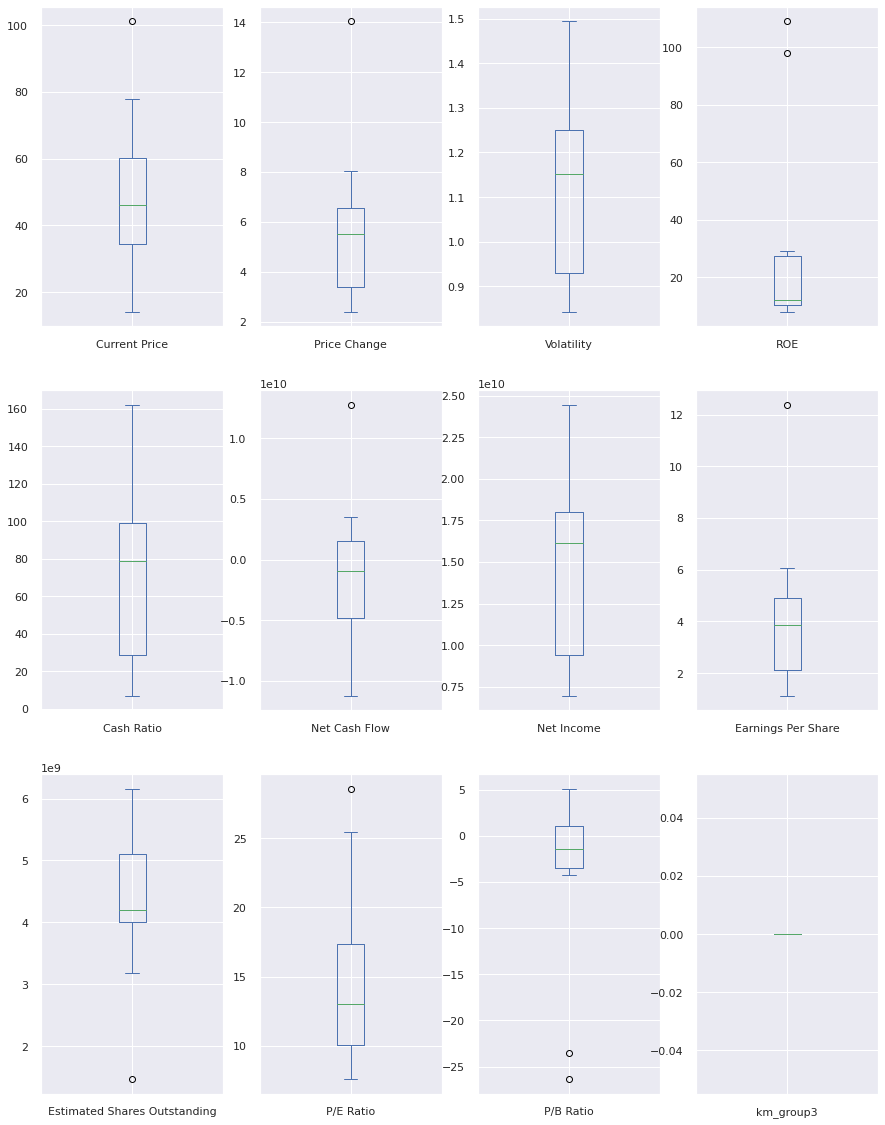

In [ ]:
data.query('km_group==5').drop(['km_group','ag_group'],axis=1).plot(
    kind='box',
    subplots=True,
    sharey=False,
    layout=(3,4),
    figsize=(15,20));

* Stock prices in group 5 are fairly low, and the lower P/E ratio suggests these are not overvalued.
* The volatility of stocks in group 5 is among the lowest of the groups.
* From our cluster analysis earlier, we recall that group 5 has the stocks with the highest net income.

I might advise investing in most of the stocks in group 5 to build a diverse portfolio. Perhaps I would leave out Pfizer and Coca Cola, as their P/E ratios are higher than the rest (25 and 28 respectively).

In [ ]:
data.query('km_group==3')['GICS Sector'].value_counts()

Energy                    21
Industrials                2
Materials                  2
Information Technology     2
Name: GICS Sector, dtype: int64

I would advise against building a portfolio entirely on group 3. This groups is comprised almost entirely of energy securities. As was discussed before, a disruption in the energy industry would negatively impact all of these stocks, bringing down the value of the portfolio significantly.

### Hierarchical

Let's look at group 4 from hierarchical clustering.

In [ ]:
data.query('ag_group==4')

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,km_group,km_group3,ag_group
52,C,Citigroup Inc.,Financials,Banks,51.750000,4.714695,1.261984,8,99,-11208000000,17242000000,5.41,3.187061e+09,9.565619,-1.167533,5,0,4
123,F,Ford Motor,Consumer Discretionary,Automobile Manufacturers,14.090000,2.398256,1.151454,26,43,3515000000,7373000000,1.86,3.963978e+09,7.575269,5.108756,5,0,4
177,JPM,JPMorgan Chase & Co.,Financials,Banks,66.029999,8.033377,1.130337,10,99,-7341000000,24442000000,6.05,4.040000e+09,10.914049,-1.886881,5,0,4
181,KO,Coca Cola Company,Consumer Staples,Soft Drinks,42.959999,6.812526,0.889913,29,74,-1649000000,7351000000,1.69,4.349704e+09,25.420118,-1.466307,5,0,4
246,PFE,Pfizer Inc.,Health Care,Pharmaceuticals,32.279999,3.130991,1.238748,11,79,298000000,6960000000,1.13,6.159292e+09,28.566371,-4.213309,5,0,4
287,T,AT&T Inc,Telecommunications Services,Integrated Telecommunications Services,34.410000,5.942118,0.859442,11,11,-3482000000,13345000000,2.37,5.630802e+09,14.518987,-23.537323,5,0,4
317,VZ,Verizon Communications,Telecommunications Services,Integrated Telecommunications Services,46.220001,6.277303,0.842592,109,14,-6128000000,17879000000,4.38,4.081963e+09,10.552512,-26.380687,5,0,4
320,WFC,Wells Fargo,Financials,Banks,54.360001,5.532912,0.969774,12,99,-460000000,22894000000,4.18,5.477033e+09,13.004785,-0.938007,5,0,4
331,XOM,Exxon Mobil Corp.,Energy,Integrated Oil & Gas,77.949997,3.656915,1.370062,9,7,-911000000,16150000000,3.85,4.194805e+09,20.246752,-2.706443,5,0,4


* From our analyses earlier, recall that group 4 has a steady positive price change.
* While the price is going up, the stocks are still affordable and are not overvalued (P/E ratio).
* There is a good mix of GICS sectors in this group.

This would be the group I would build a portfolio on. What's more, this group is a subset of the k-means group just described! Summarily, both clustering methods identified a group with almost the same high-performing, diversified stocks.